# KAMA-MSR Model Comparison and Analysis

This notebook loads multiple KAMA-MSR models, compares their characteristics, and identifies potential areas for improvement.

## 1. Import Required Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import skew, kurtosis
import pickle
import os
from typing import Dict, List, Tuple
from datetime import datetime
import warnings

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load All Models from Directory

In [62]:
def load_all_models(sub_folder: str, edte_sub_folder: str, n_regimes: int = 2) -> Dict:
    """
    Load all KAMA-MSR models from a specified directory.
    
    Parameters:
    -----------
    sub_folder : str
        Asset type subfolder (e.g., 'us_equity', 'international_index')
    edte_sub_folder : str
        End date subfolder (e.g., '20220101')
    n_regimes : int
        Number of MSR regimes (used to construct filename)
    
    Returns:
    --------
    Dict : Dictionary with asset names as keys and loaded models as values
    """
    models = {}
    model_dir = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}'
    
    if not os.path.exists(model_dir):
        print(f"❌ Directory not found: {model_dir}")
        return models
    
    print(f"Loading models from: {model_dir}\n")
    
    # Get all pickle files
    pkl_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl') and f != 'metadata.pkl']
    
    for filename in pkl_files:
        filepath = os.path.join(model_dir, filename)
        
        try:
            with open(filepath, 'rb') as f:
                model = pickle.load(f)
            
            # Extract asset name from filename
            # Format: AssetName_KAMA-MSR_X-regimes.pkl
            asset_name = filename.replace('_KAMA-MSR_', '|||').split('|||')[0]
            asset_name = asset_name.replace('_', ' ')
            
            models[asset_name] = model
            print(f"✓ Loaded: {asset_name}")
            
        except Exception as e:
            print(f"❌ Error loading {filename}: {str(e)}")
    
    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(models)} models")
    print(f"{'='*80}\n")
    
    return models

def get_available_model_folders() -> pd.DataFrame:
    """
    Scan the saved_models directory to show available model configurations.
    
    Returns:
    --------
    pd.DataFrame : Summary of available model folders
    """
    base_dir = 'saved_models/KAMA_MSR'
    
    if not os.path.exists(base_dir):
        print(f"❌ Base directory not found: {base_dir}")
        return pd.DataFrame()
    
    folders = []
    
    for asset_type in os.listdir(base_dir):
        asset_type_path = os.path.join(base_dir, asset_type)
        
        if not os.path.isdir(asset_type_path):
            continue
            
        for date_folder in os.listdir(asset_type_path):
            date_folder_path = os.path.join(asset_type_path, date_folder)
            
            if not os.path.isdir(date_folder_path):
                continue
            
            # Count models
            pkl_files = [f for f in os.listdir(date_folder_path) 
                        if f.endswith('.pkl') and f != 'metadata.pkl']
            
            if pkl_files:
                folders.append({
                    'Asset Type': asset_type,
                    'End Date': date_folder,
                    'N Models': len(pkl_files),
                    'Path': f"{asset_type}/{date_folder}"
                })
    
    df = pd.DataFrame(folders)
    return df.sort_values(['Asset Type', 'End Date']) if not df.empty else df

In [63]:
# Display available model configurations
available_models = get_available_model_folders()
print("Available Model Configurations:")
print("="*80)
if not available_models.empty:
    display(available_models)
else:
    print("No models found!")

Available Model Configurations:


,Asset Type,End Date,N Models,Path
2,us_bond,20220101,3,us_bond/20220101
0,us_equity,20220101,26,us_equity/20220101
1,us_traded_international_equity_etfs,20220101,8,us_traded_international_equity_etfs/20220101


In [64]:
# Load models - ADJUST THESE PARAMETERS
sub_folder = 'us_equity'  # Change to your asset type
edte_sub_folder = '20220101'  # Change to your date
n_regimes = 2

models = load_all_models(sub_folder, edte_sub_folder, n_regimes)

if models:
    print(f"\nLoaded models for assets:")
    for i, asset_name in enumerate(models.keys(), 1):
        print(f"  {i:2d}. {asset_name}")

Loading models from: saved_models/KAMA_MSR/us_equity/20220101

✓ Loaded: Consumer Discretionary Select Sector SPDR
✓ Loaded: Nasdaq 100
✓ Loaded: Consumer Staples Select Sector SPDR
✓ Loaded: iShares Micro-Cap ETF
✓ Loaded: Invesco S&P 500 Equal Weight ETF
✓ Loaded: Nasdaq Composite
✓ Loaded: iShares Russell 2000 ETF
✓ Loaded: Financial Select Sector SPDR
✓ Loaded: iShares S&P 500 Value ETF
✓ Loaded: Health Care Select Sector SPDR
✓ Loaded: iShares Russell 2000 Value ETF
✓ Loaded: iShares S&P 500 Growth ETF
✓ Loaded: Invesco QQQ Trust
✓ Loaded: Russell 2000
✓ Loaded: SPDR Dow Jones Industrial Average ETF
✓ Loaded: SPDR S&P 500 ETF
✓ Loaded: Russell 2000
✓ Loaded: SPDR Dow Jones Industrial Average ETF
✓ Loaded: SPDR S&P 500 ETF
✓ Loaded: iShares Russell 2000 Growth ETF
✓ Loaded: Dow Jones Industrial Average
✓ Loaded: iShares Russell Mid-Cap ETF
✓ Loaded: S&P 500
✓ Loaded: Technology Select Sector SPDR
✓ Loaded: Fidelity Nasdaq Composite Index ETF
✓ Loaded: Energy Select Sector SPDR
✓ Lo

## 3. Extract Model Metadata and Parameters

In [65]:
def extract_model_metadata(models: Dict) -> pd.DataFrame:
    """
    Extract comprehensive metadata from all loaded models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Comprehensive metadata for all models
    """
    metadata = []
    
    for asset_name, model in models.items():
        try:
            # Basic info
            n_data_points = len(model.prices) if model.prices is not None else 0
            n_regimes_msr = model.msr.n_regimes
            n_combined_regimes = model.n_combined_regimes
            
            # KAMA parameters
            kama_n = model.kama.n
            kama_n_fast = model.kama.n_fast
            kama_n_slow = model.kama.n_slow
            
            # Filter parameters
            n_lookback = model.n_lookback
            gamma = model.gamma
            
            # Regime labels
            regime_labels = model.regime_labels.dropna()
            n_regime_changes = (regime_labels.diff() != 0).sum()
            
            # Regime distribution
            regime_counts = regime_labels.value_counts()
            regime_pcts = regime_counts / len(regime_labels) * 100
            
            # MSR parameters
            msr_means = model.msr.means
            msr_stds = model.msr.stds
            msr_betas = model.msr.betas
            
            # Build metadata dict
            meta = {
                'Asset': asset_name,
                'N_Data_Points': n_data_points,
                'N_MSR_Regimes': n_regimes_msr,
                'N_Combined_Regimes': n_combined_regimes,
                'KAMA_n': kama_n,
                'KAMA_n_fast': kama_n_fast,
                'KAMA_n_slow': kama_n_slow,
                'Filter_n_lookback': n_lookback,
                'Filter_gamma': gamma,
                'N_Regime_Changes': n_regime_changes,
                'Avg_Regime_Duration': len(regime_labels) / (n_regime_changes + 1),
            }
            
            # Add regime-specific data
            for i in range(n_combined_regimes):
                meta[f'Regime_{i}_Pct'] = regime_pcts.get(i, 0)
                meta[f'Regime_{i}_Count'] = regime_counts.get(i, 0)
            
            # Add MSR parameters
            for i in range(n_regimes_msr):
                meta[f'MSR_Mean_{i}'] = msr_means[i]
                meta[f'MSR_Std_{i}'] = msr_stds[i]
                meta[f'MSR_Beta_{i}'] = msr_betas[i]
            
            # Add transition probabilities
            for i in range(n_regimes_msr):
                for j in range(n_regimes_msr):
                    meta[f'Trans_P_{i}_to_{j}'] = model.msr.transition_probs[i, j]
            
            metadata.append(meta)
            
        except Exception as e:
            print(f"❌ Error extracting metadata for {asset_name}: {str(e)}")
    
    df = pd.DataFrame(metadata)
    return df

# Extract metadata
metadata_df = extract_model_metadata(models)

print("\nModel Metadata Summary:")
print("="*80)
display(metadata_df.head())

print(f"\nShape: {metadata_df.shape}")
print(f"Columns: {list(metadata_df.columns)}")


Model Metadata Summary:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_n_lookback,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
0,Consumer Discretionary Select Sector SPDR,5795,2,4,18,10,60,20,2.00,85,67.1512,76.7446,4432,14.9091,861,1.2814,74,7.0649,408,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307
1,Nasdaq 100,8064,2,4,30,10,60,20,2.00,94,84.6737,73.9557,5949,8.1054,652,8.1179,653,9.8210,790,0.0010,0.0127,0.0036,-0.0019,0.0333,-0.0617,0.9933,0.0067,0.0307,0.9693
2,Consumer Staples Select Sector SPDR,5795,2,4,27,10,35,20,0.50,116,49.3590,72.1385,4166,25.6277,1480,0.2424,14,1.9913,115,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215
3,iShares Micro-Cap ETF,4124,2,4,6,2,25,20,1.75,214,19.0884,47.9288,1967,43.4698,1784,2.8509,117,5.7505,236,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509
4,Invesco S&P 500 Equal Weight ETF,4703,2,4,5,9,35,20,0.50,86,53.8276,71.2150,3335,20.6492,967,1.0463,49,7.0895,332,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573



Shape: (26, 29)
Columns: ['Asset', 'N_Data_Points', 'N_MSR_Regimes', 'N_Combined_Regimes', 'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_n_lookback', 'Filter_gamma', 'N_Regime_Changes', 'Avg_Regime_Duration', 'Regime_0_Pct', 'Regime_0_Count', 'Regime_1_Pct', 'Regime_1_Count', 'Regime_2_Pct', 'Regime_2_Count', 'Regime_3_Pct', 'Regime_3_Count', 'MSR_Mean_0', 'MSR_Std_0', 'MSR_Beta_0', 'MSR_Mean_1', 'MSR_Std_1', 'MSR_Beta_1', 'Trans_P_0_to_0', 'Trans_P_0_to_1', 'Trans_P_1_to_0', 'Trans_P_1_to_1']


## 4. Compare KAMA Parameters Across Assets

In [66]:
# Summary statistics for KAMA parameters
kama_cols = ['KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow']
kama_summary = metadata_df[['Asset'] + kama_cols].describe()

print("KAMA Parameter Summary Statistics:")
print("="*80)
display(kama_summary)

# Identify unique parameter combinations
unique_kama = metadata_df[kama_cols].drop_duplicates()
print(f"\nNumber of unique KAMA parameter combinations: {len(unique_kama)}")
print("\nUnique KAMA configurations:")
display(unique_kama)

KAMA Parameter Summary Statistics:


,KAMA_n,KAMA_n_fast,KAMA_n_slow
count,26.0000,26.0000,26.0000
mean,22.0000,9.3462,50.5769
std,8.6764,1.9171,12.0272
min,5.0000,2.0000,25.0000
25%,15.0000,10.0000,41.2500
50%,27.0000,10.0000,57.5000
75%,29.5000,10.0000,60.0000
max,30.0000,10.0000,60.0000



Number of unique KAMA parameter combinations: 19

Unique KAMA configurations:


,KAMA_n,KAMA_n_fast,KAMA_n_slow
0,18,10,60
1,30,10,60
2,27,10,35
3,6,2,25
4,5,9,35
5,25,10,60
7,28,10,55
8,30,9,50
10,13,10,60
11,13,10,35


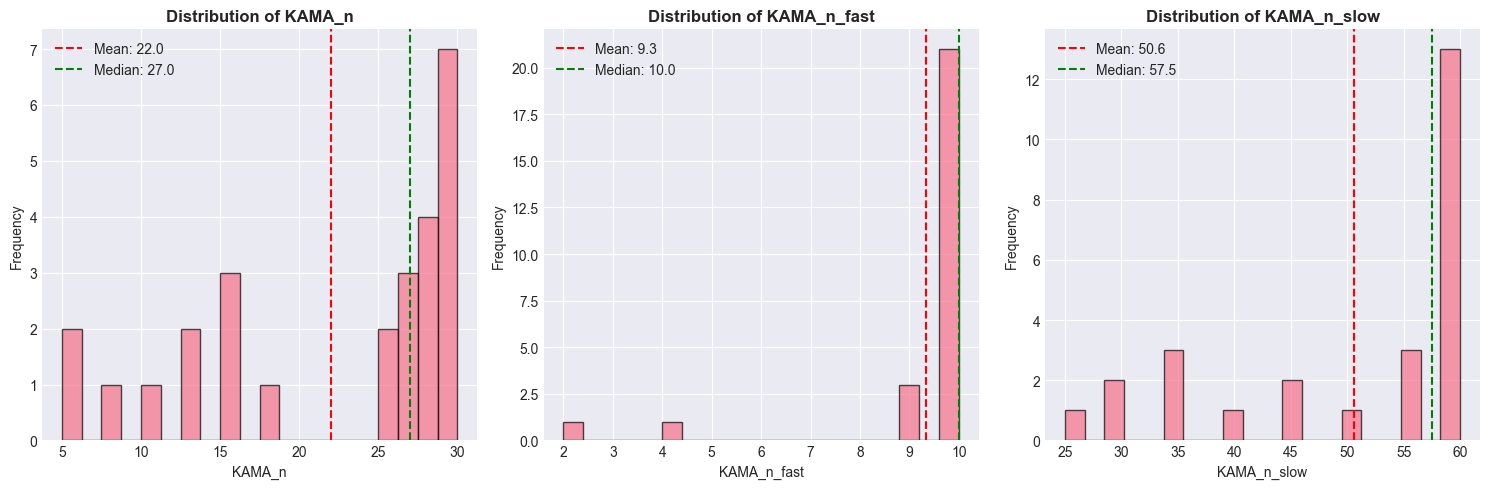

In [67]:
# Visualize KAMA parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(kama_cols):
    ax = axes[idx]
    metadata_df[col].hist(bins=20, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.axvline(metadata_df[col].mean(), color='red', linestyle='--', 
               label=f'Mean: {metadata_df[col].mean():.1f}')
    ax.axvline(metadata_df[col].median(), color='green', linestyle='--', 
               label=f'Median: {metadata_df[col].median():.1f}')
    ax.legend()

plt.tight_layout()
plt.show()

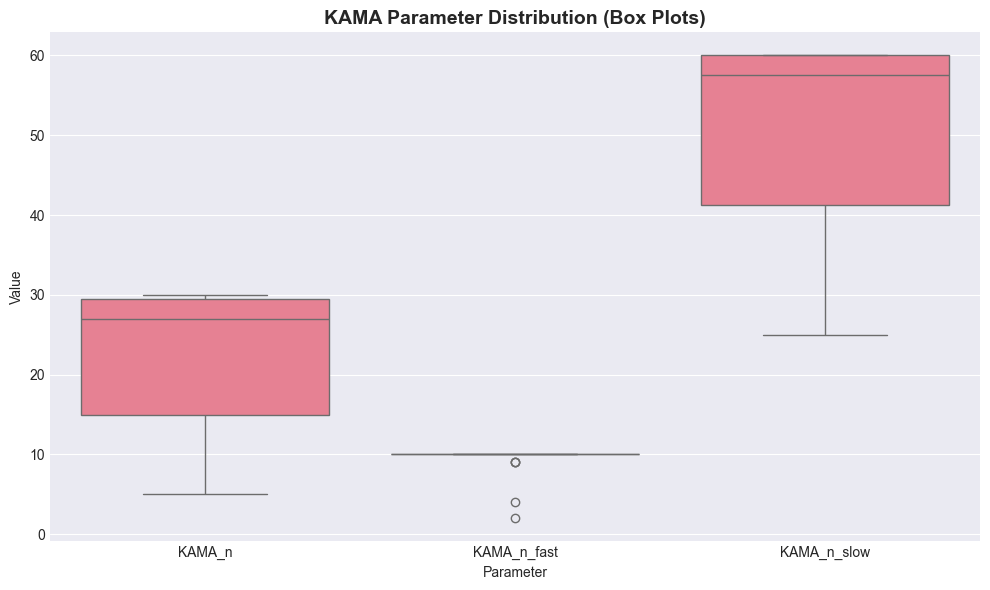


KAMA Parameter Outliers (values > 1.5 IQR):

KAMA_n_fast:
  iShares Micro-Cap ETF: 2
  Invesco S&P 500 Equal Weight ETF: 9
  iShares S&P 500 Value ETF: 9
  Fidelity Nasdaq Composite Index ETF: 9
  Utilities Select Sector SPDR: 4


In [68]:
# Box plots for KAMA parameters
fig, ax = plt.subplots(figsize=(10, 6))

kama_data = metadata_df[kama_cols].melt(var_name='Parameter', value_name='Value')
sns.boxplot(data=kama_data, x='Parameter', y='Value', ax=ax)
ax.set_title('KAMA Parameter Distribution (Box Plots)', fontsize=14, fontweight='bold')
ax.set_ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify outliers
print("\nKAMA Parameter Outliers (values > 1.5 IQR):")
print("="*80)
for col in kama_cols:
    Q1 = metadata_df[col].quantile(0.25)
    Q3 = metadata_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = metadata_df[(metadata_df[col] < Q1 - 1.5*IQR) | (metadata_df[col] > Q3 + 1.5*IQR)]
    if len(outliers) > 0:
        print(f"\n{col}:")
        for _, row in outliers.iterrows():
            print(f"  {row['Asset']}: {row[col]}")

## 5. Compare MSR Parameters Across Assets

In [69]:
# Extract MSR parameter columns
msr_mean_cols = [col for col in metadata_df.columns if col.startswith('MSR_Mean_')]
msr_std_cols = [col for col in metadata_df.columns if col.startswith('MSR_Std_')]
msr_beta_cols = [col for col in metadata_df.columns if col.startswith('MSR_Beta_')]

print("MSR Parameter Summary Statistics:")
print("="*80)

print("\nMSR Means:")
display(metadata_df[['Asset'] + msr_mean_cols].describe())

print("\nMSR Standard Deviations:")
display(metadata_df[['Asset'] + msr_std_cols].describe())

print("\nMSR Betas:")
display(metadata_df[['Asset'] + msr_beta_cols].describe())

MSR Parameter Summary Statistics:

MSR Means:


,MSR_Mean_0,MSR_Mean_1
count,26.0000,26.0000
mean,0.0006,-0.0027
std,0.0002,0.0010
min,0.0002,-0.0051
25%,0.0005,-0.0030
50%,0.0005,-0.0023
75%,0.0006,-0.0019
max,0.0010,-0.0012



MSR Standard Deviations:


,MSR_Std_0,MSR_Std_1
count,26.0000,26.0000
mean,0.0122,0.0417
std,0.0014,0.0097
min,0.0101,0.0306
25%,0.0113,0.0363
50%,0.0121,0.0391
75%,0.0129,0.0458
max,0.0157,0.0795



MSR Betas:


,MSR_Beta_0,MSR_Beta_1
count,26.0000,26.0000
mean,-0.0074,-0.0584
std,0.0082,0.0611
min,-0.0196,-0.3494
25%,-0.0138,-0.0564
50%,-0.0074,-0.0490
75%,-0.0040,-0.0397
max,0.0124,-0.0170


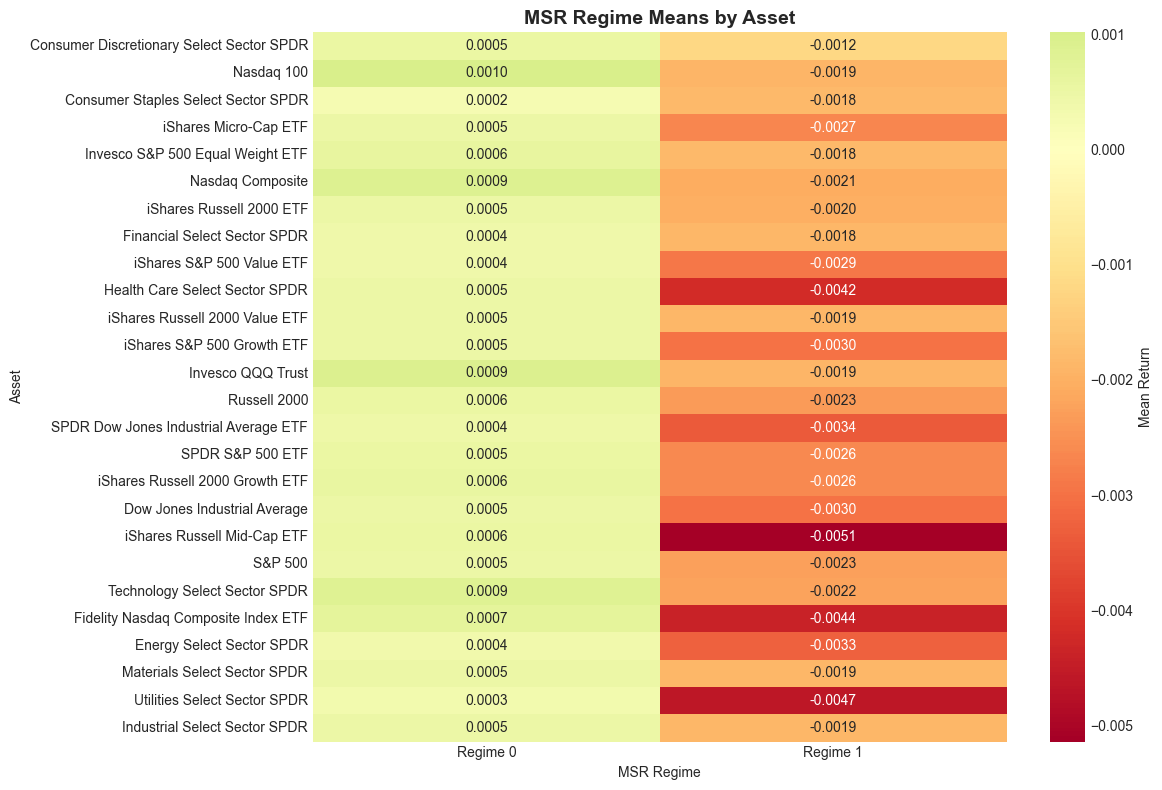

In [70]:
# Heatmap of MSR means
plt.figure(figsize=(12, 8))

msr_means_data = metadata_df[['Asset'] + msr_mean_cols].set_index('Asset')
msr_means_data.columns = [col.replace('MSR_Mean_', 'Regime ') for col in msr_means_data.columns]

sns.heatmap(msr_means_data, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mean Return'})
plt.title('MSR Regime Means by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

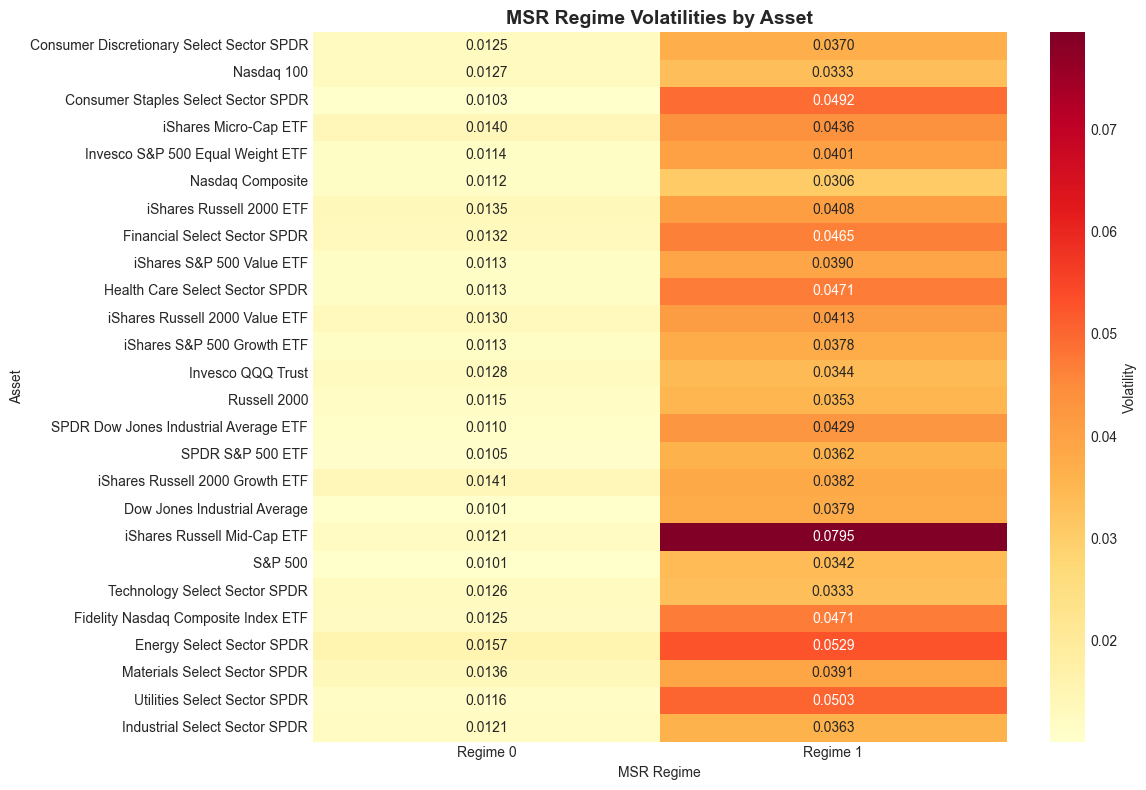

In [71]:
# Heatmap of MSR volatilities
plt.figure(figsize=(12, 8))

msr_stds_data = metadata_df[['Asset'] + msr_std_cols].set_index('Asset')
msr_stds_data.columns = [col.replace('MSR_Std_', 'Regime ') for col in msr_stds_data.columns]

sns.heatmap(msr_stds_data, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Volatility'})
plt.title('MSR Regime Volatilities by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

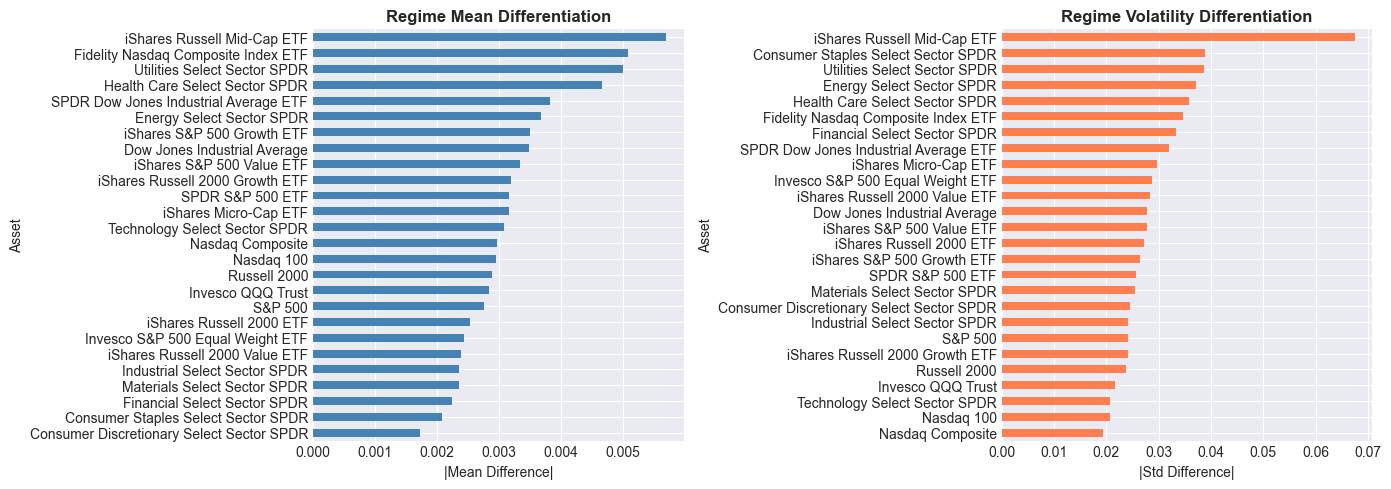


Assets with WEAK Regime Differentiation:

Lowest Mean Differentiation:


,Asset,Mean_Diff,MSR_Mean_0,MSR_Mean_1
0,Consumer Discretionary Select Sector SPDR,0.0017,0.0005,-0.0012
2,Consumer Staples Select Sector SPDR,0.0021,0.0002,-0.0018
7,Financial Select Sector SPDR,0.0022,0.0004,-0.0018
23,Materials Select Sector SPDR,0.0024,0.0005,-0.0019
25,Industrial Select Sector SPDR,0.0024,0.0005,-0.0019



Lowest Volatility Differentiation:


,Asset,Std_Diff,MSR_Std_0,MSR_Std_1
5,Nasdaq Composite,0.0193,0.0112,0.0306
1,Nasdaq 100,0.0207,0.0127,0.0333
20,Technology Select Sector SPDR,0.0207,0.0126,0.0333
12,Invesco QQQ Trust,0.0217,0.0128,0.0344
13,Russell 2000,0.0238,0.0115,0.0353


In [72]:
# Compare regime differentiation (difference between regimes)
if len(msr_mean_cols) == 2:
    metadata_df['Mean_Diff'] = abs(metadata_df['MSR_Mean_0'] - metadata_df['MSR_Mean_1'])
    metadata_df['Std_Diff'] = abs(metadata_df['MSR_Std_0'] - metadata_df['MSR_Std_1'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean difference
    metadata_df.sort_values('Mean_Diff').plot.barh(x='Asset', y='Mean_Diff', ax=axes[0], 
                                                     color='steelblue', legend=False)
    axes[0].set_title('Regime Mean Differentiation', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('|Mean Difference|')
    
    # Std difference
    metadata_df.sort_values('Std_Diff').plot.barh(x='Asset', y='Std_Diff', ax=axes[1], 
                                                    color='coral', legend=False)
    axes[1].set_title('Regime Volatility Differentiation', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('|Std Difference|')
    
    plt.tight_layout()
    plt.show()
    
    print("\nAssets with WEAK Regime Differentiation:")
    print("="*80)
    print("\nLowest Mean Differentiation:")
    display(metadata_df.nsmallest(5, 'Mean_Diff')[['Asset', 'Mean_Diff', 'MSR_Mean_0', 'MSR_Mean_1']])
    
    print("\nLowest Volatility Differentiation:")
    display(metadata_df.nsmallest(5, 'Std_Diff')[['Asset', 'Std_Diff', 'MSR_Std_0', 'MSR_Std_1']])

## 6. Regime Distribution Analysis

In [73]:
# Regime distribution summary
regime_pct_cols = [col for col in metadata_df.columns if col.startswith('Regime_') and col.endswith('_Pct')]

print("Regime Distribution Summary:")
print("="*80)
display(metadata_df[['Asset'] + regime_pct_cols].describe())

# Identify imbalanced regimes
print("\nAssets with Imbalanced Regime Distributions:")
print("="*80)

for _, row in metadata_df.iterrows():
    pcts = [row[col] for col in regime_pct_cols]
    max_pct = max(pcts)
    min_pct = min(pcts)
    
    if max_pct > 70:  # One regime dominates
        print(f"\n{row['Asset']}:")
        for i, col in enumerate(regime_pct_cols):
            print(f"  Regime {i}: {row[col]:.1f}%")

Regime Distribution Summary:


,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
count,26.0000,26.0000,26.0000,26.0000
mean,71.0382,20.4574,1.6994,6.8050
std,7.1553,8.2119,2.1996,2.8971
min,47.9288,8.1054,0.0173,1.9913
25%,70.6328,16.0039,0.4572,4.7710
50%,72.5175,19.3333,0.8195,6.8534
75%,75.3014,22.3826,1.5769,7.9331
max,78.9160,43.4698,8.1179,13.1924



Assets with Imbalanced Regime Distributions:

Consumer Discretionary Select Sector SPDR:
  Regime 0: 76.7%
  Regime 1: 14.9%
  Regime 2: 1.3%
  Regime 3: 7.1%

Nasdaq 100:
  Regime 0: 74.0%
  Regime 1: 8.1%
  Regime 2: 8.1%
  Regime 3: 9.8%

Consumer Staples Select Sector SPDR:
  Regime 0: 72.1%
  Regime 1: 25.6%
  Regime 2: 0.2%
  Regime 3: 2.0%

Invesco S&P 500 Equal Weight ETF:
  Regime 0: 71.2%
  Regime 1: 20.6%
  Regime 2: 1.0%
  Regime 3: 7.1%

Nasdaq Composite:
  Regime 0: 73.4%
  Regime 1: 10.7%
  Regime 2: 5.7%
  Regime 3: 10.2%

iShares Russell 2000 ETF:
  Regime 0: 71.0%
  Regime 1: 20.9%
  Regime 2: 0.8%
  Regime 3: 7.2%

Health Care Select Sector SPDR:
  Regime 0: 78.8%
  Regime 1: 18.3%
  Regime 2: 0.6%
  Regime 3: 2.3%

iShares Russell 2000 Value ETF:
  Regime 0: 70.6%
  Regime 1: 20.7%
  Regime 2: 0.7%
  Regime 3: 8.0%

iShares S&P 500 Growth ETF:
  Regime 0: 70.8%
  Regime 1: 22.5%
  Regime 2: 0.6%
  Regime 3: 6.1%

Invesco QQQ Trust:
  Regime 0: 71.0%
  Regime 1: 9.0

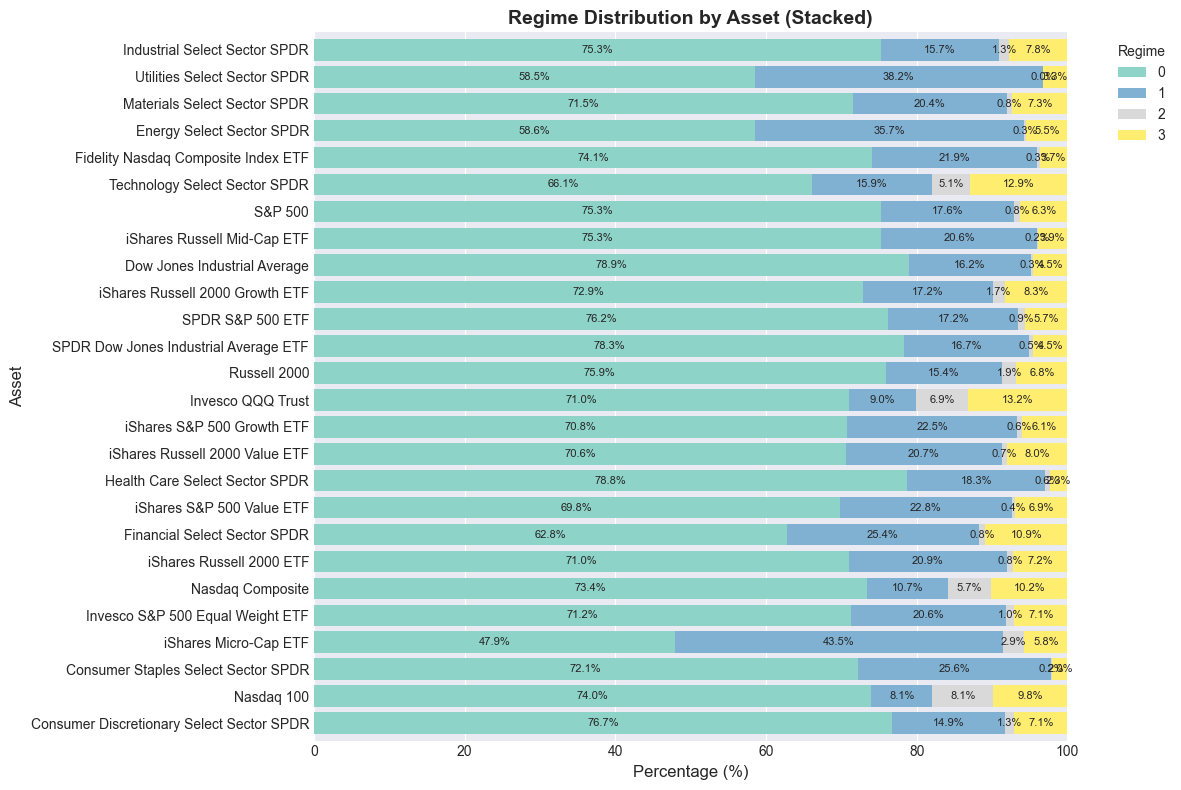

In [74]:
# Stacked bar chart of regime distributions
regime_pct_data = metadata_df[['Asset'] + regime_pct_cols].set_index('Asset')
regime_pct_data.columns = [col.replace('Regime_', '').replace('_Pct', '') for col in regime_pct_data.columns]

ax = regime_pct_data.plot.barh(stacked=True, figsize=(12, max(8, len(models)*0.3)), 
                                colormap='Set3', width=0.8)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('Asset', fontsize=12)
ax.set_title('Regime Distribution by Asset (Stacked)', fontsize=14, fontweight='bold')
ax.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, 100)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)

plt.tight_layout()
plt.show()

Regime Diversity Scores:
(0 = Perfectly balanced, 1 = Completely concentrated)



,Asset,Regime_Diversity_Score,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
9,Health Care Select Sector SPDR,0.5538,78.7706,18.2511,0.6407,2.3377
17,Dow Jones Industrial Average,0.5375,78.9160,16.2233,0.3357,4.5251
14,SPDR Dow Jones Industrial Average ETF,0.5261,78.2992,16.6583,0.4993,4.5432
18,iShares Russell Mid-Cap ETF,0.5124,75.3024,20.6399,0.1561,3.9017
2,Consumer Staples Select Sector SPDR,0.5116,72.1385,25.6277,0.2424,1.9913
21,Fidelity Nasdaq Composite Index ETF,0.4997,74.0822,21.9406,0.2841,3.6932
15,SPDR S&P 500 ETF,0.4850,76.2285,17.2195,0.8672,5.6848
0,Consumer Discretionary Select Sector SPDR,0.4735,76.7446,14.9091,1.2814,7.0649
19,S&P 500,0.4720,75.2984,17.6405,0.8081,6.2531
13,Russell 2000,0.4548,75.8826,15.4152,1.9020,6.8001


<Figure size 1000x780 with 0 Axes>

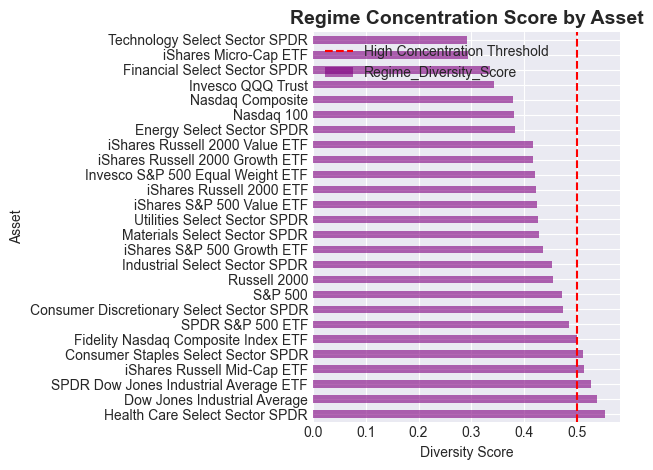

In [75]:
# Regime diversity metric (entropy-based)
from scipy.stats import entropy

def regime_diversity_score(pcts):
    """Calculate normalized entropy as diversity score (0=uniform, 1=concentrated)"""
    pcts_normalized = np.array(pcts) / 100.0
    max_entropy = np.log(len(pcts))
    return 1 - (entropy(pcts_normalized) / max_entropy) if max_entropy > 0 else 0

metadata_df['Regime_Diversity_Score'] = metadata_df.apply(
    lambda row: regime_diversity_score([row[col] for col in regime_pct_cols]), axis=1
)

print("Regime Diversity Scores:")
print("="*80)
print("(0 = Perfectly balanced, 1 = Completely concentrated)\n")

diversity_sorted = metadata_df[['Asset', 'Regime_Diversity_Score'] + regime_pct_cols].sort_values('Regime_Diversity_Score', ascending=False)
display(diversity_sorted)

# Visualize
plt.figure(figsize=(10, max(6, len(models)*0.3)))
diversity_sorted.plot.barh(x='Asset', y='Regime_Diversity_Score', 
                           color='purple', alpha=0.6, legend=False)
plt.axvline(0.5, color='red', linestyle='--', label='High Concentration Threshold')
plt.xlabel('Diversity Score')
plt.ylabel('Asset')
plt.title('Regime Concentration Score by Asset', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Regime Duration Analysis

In [76]:
def extract_regime_duration_stats(models: Dict) -> pd.DataFrame:
    """
    Extract regime duration statistics from all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Regime duration statistics for all models
    """
    duration_stats = []
    
    for asset_name, model in models.items():
        try:
            regime_labels = model.regime_labels.dropna()
            
            # Calculate regime durations
            regime_changes = regime_labels != regime_labels.shift(1)
            regime_blocks = regime_changes.cumsum()
            
            durations = regime_labels.groupby(regime_blocks).size()
            
            stats = {
                'Asset': asset_name,
                'Mean_Duration': durations.mean(),
                'Median_Duration': durations.median(),
                'Std_Duration': durations.std(),
                'Min_Duration': durations.min(),
                'Max_Duration': durations.max(),
                'Q25_Duration': durations.quantile(0.25),
                'Q75_Duration': durations.quantile(0.75),
                'N_Regimes': len(durations),
                'Pct_Single_Period': (durations == 1).sum() / len(durations) * 100
            }
            
            duration_stats.append(stats)
            
        except Exception as e:
            print(f"❌ Error extracting duration stats for {asset_name}: {str(e)}")
    
    return pd.DataFrame(duration_stats)

duration_df = extract_regime_duration_stats(models)

print("Regime Duration Statistics:")
print("="*80)
display(duration_df.sort_values('Mean_Duration', ascending=False))

Regime Duration Statistics:


,Asset,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period
14,SPDR Dow Jones Industrial Average ETF,87.0725,26.0,163.9618,1,961,8.00,72.00,69,5.7971
16,iShares Russell 2000 Growth ETF,85.2540,25.0,160.1910,1,960,11.50,79.50,63,3.1746
1,Nasdaq 100,84.6632,27.0,148.6043,1,999,10.50,92.50,95,3.1579
10,iShares Russell 2000 Value ETF,82.6308,25.0,163.8140,1,1062,8.00,87.00,65,6.1538
12,Invesco QQQ Trust,81.7429,26.5,148.4934,1,999,8.00,92.50,70,4.2857
15,SPDR S&P 500 ETF,75.6667,19.0,165.4817,1,1078,6.75,44.25,96,6.2500
5,Nasdaq Composite,73.7890,24.0,141.7340,1,934,9.00,72.00,109,6.4220
25,Industrial Select Sector SPDR,72.1750,19.5,143.6531,1,790,5.75,59.75,80,1.2500
19,S&P 500,70.5526,19.0,133.2870,1,796,6.00,67.75,114,5.2632
18,iShares Russell Mid-Cap ETF,70.2055,18.0,115.8858,1,481,6.00,68.00,73,10.9589


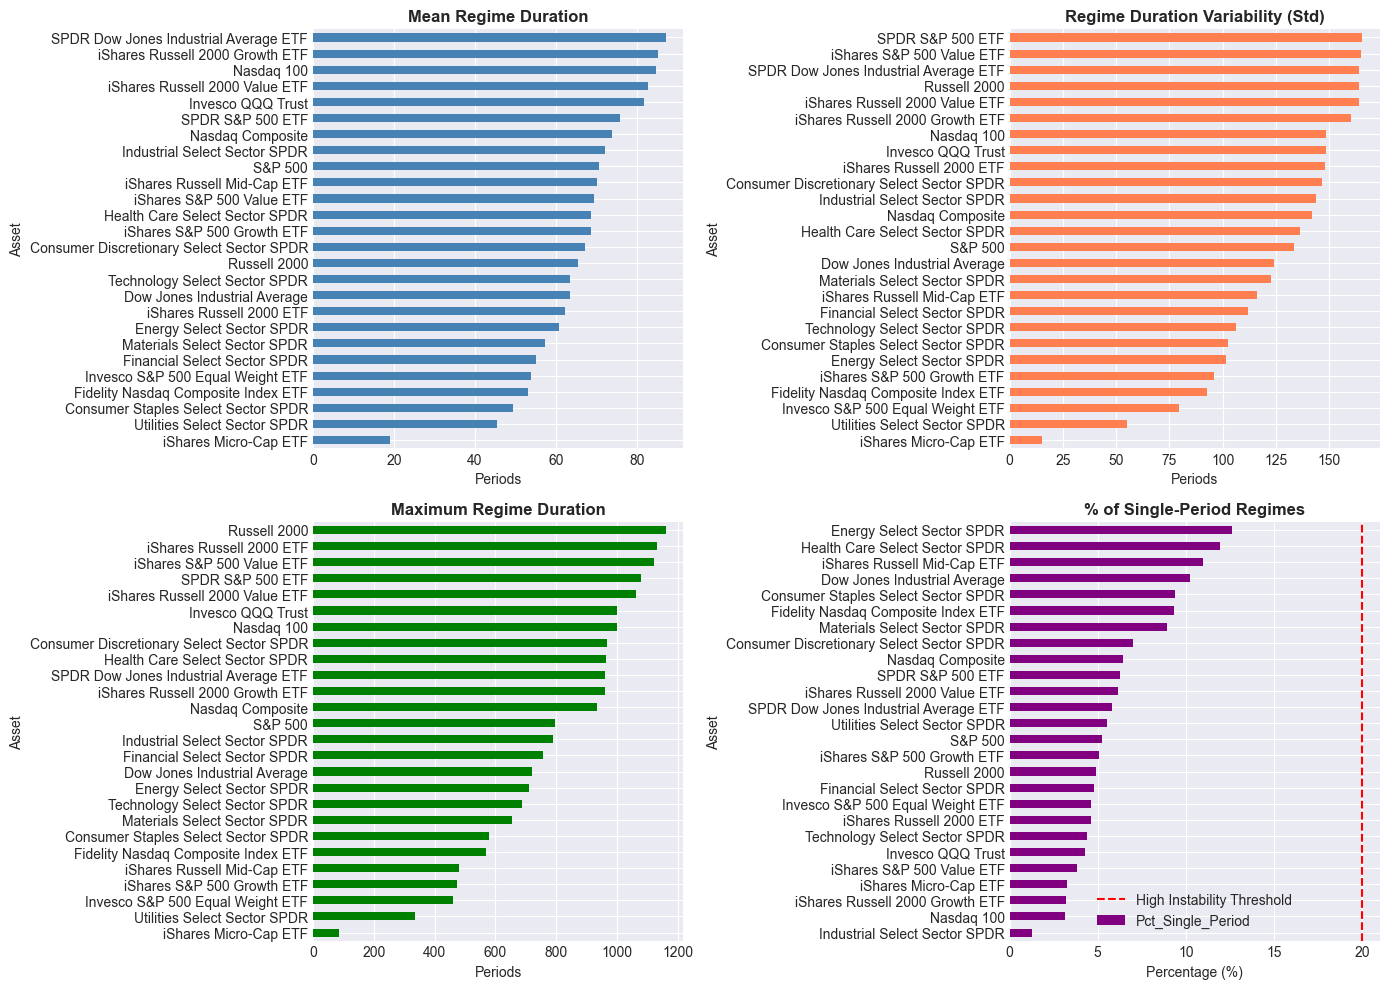

In [77]:
# Visualize regime duration characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean duration
duration_df.sort_values('Mean_Duration').plot.barh(x='Asset', y='Mean_Duration', 
                                                     ax=axes[0,0], color='steelblue', legend=False)
axes[0,0].set_title('Mean Regime Duration', fontweight='bold')
axes[0,0].set_xlabel('Periods')

# Duration variability (std)
duration_df.sort_values('Std_Duration').plot.barh(x='Asset', y='Std_Duration', 
                                                    ax=axes[0,1], color='coral', legend=False)
axes[0,1].set_title('Regime Duration Variability (Std)', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Max duration
duration_df.sort_values('Max_Duration').plot.barh(x='Asset', y='Max_Duration', 
                                                    ax=axes[1,0], color='green', legend=False)
axes[1,0].set_title('Maximum Regime Duration', fontweight='bold')
axes[1,0].set_xlabel('Periods')

# Percentage of single-period regimes
duration_df.sort_values('Pct_Single_Period').plot.barh(x='Asset', y='Pct_Single_Period', 
                                                         ax=axes[1,1], color='purple', legend=False)
axes[1,1].set_title('% of Single-Period Regimes', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(20, color='red', linestyle='--', label='High Instability Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [78]:
# Identify problematic duration patterns
print("Assets with Regime Duration Issues:")
print("="*80)

print("\n1. HIGH REGIME INSTABILITY (>20% single-period regimes):")
unstable = duration_df[duration_df['Pct_Single_Period'] > 20].sort_values('Pct_Single_Period', ascending=False)
if len(unstable) > 0:
    display(unstable[['Asset', 'Pct_Single_Period', 'Mean_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

print("\n2. VERY SHORT AVERAGE DURATIONS (<5 periods):")
short_duration = duration_df[duration_df['Mean_Duration'] < 5].sort_values('Mean_Duration')
if len(short_duration) > 0:
    display(short_duration[['Asset', 'Mean_Duration', 'Median_Duration', 'Pct_Single_Period']])
else:
    print("  ✓ None found")

print("\n3. VERY LONG AVERAGE DURATIONS (>50 periods):")
long_duration = duration_df[duration_df['Mean_Duration'] > 50].sort_values('Mean_Duration', ascending=False)
if len(long_duration) > 0:
    display(long_duration[['Asset', 'Mean_Duration', 'Max_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

Assets with Regime Duration Issues:

1. HIGH REGIME INSTABILITY (>20% single-period regimes):
  ✓ None found

2. VERY SHORT AVERAGE DURATIONS (<5 periods):
  ✓ None found

3. VERY LONG AVERAGE DURATIONS (>50 periods):


,Asset,Mean_Duration,Max_Duration,N_Regimes
14,SPDR Dow Jones Industrial Average ETF,87.0725,961,69
16,iShares Russell 2000 Growth ETF,85.2540,960,63
1,Nasdaq 100,84.6632,999,95
10,iShares Russell 2000 Value ETF,82.6308,1062,65
12,Invesco QQQ Trust,81.7429,999,70
15,SPDR S&P 500 ETF,75.6667,1078,96
5,Nasdaq Composite,73.7890,934,109
25,Industrial Select Sector SPDR,72.1750,790,80
19,S&P 500,70.5526,796,114
18,iShares Russell Mid-Cap ETF,70.2055,481,73


## 8. Transition Probability Comparison

In [79]:
# Extract transition probability columns
trans_prob_cols = [col for col in metadata_df.columns if col.startswith('Trans_P_')]

print("Transition Probability Summary:")
print("="*80)
display(metadata_df[['Asset'] + trans_prob_cols].describe())

# Calculate average transition probabilities
print("\n\nAverage Transition Probabilities Across All Assets:")
avg_trans_probs = metadata_df[trans_prob_cols].mean()
for col in trans_prob_cols:
    from_regime = col.split('_')[2]
    to_regime = col.split('_')[4]
    print(f"  P({from_regime} → {to_regime}): {avg_trans_probs[col]:.4f}")

Transition Probability Summary:


,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
count,26.0000,26.0000,26.0000,26.0000
mean,0.9946,0.0054,0.0693,0.9307
std,0.0011,0.0011,0.0361,0.0361
min,0.9920,0.0040,0.0248,0.8215
25%,0.9937,0.0047,0.0438,0.9164
50%,0.9947,0.0053,0.0628,0.9372
75%,0.9953,0.0063,0.0836,0.9562
max,0.9960,0.0080,0.1785,0.9752




Average Transition Probabilities Across All Assets:
  P(0 → 0): 0.9946
  P(0 → 1): 0.0054
  P(1 → 0): 0.0693
  P(1 → 1): 0.9307


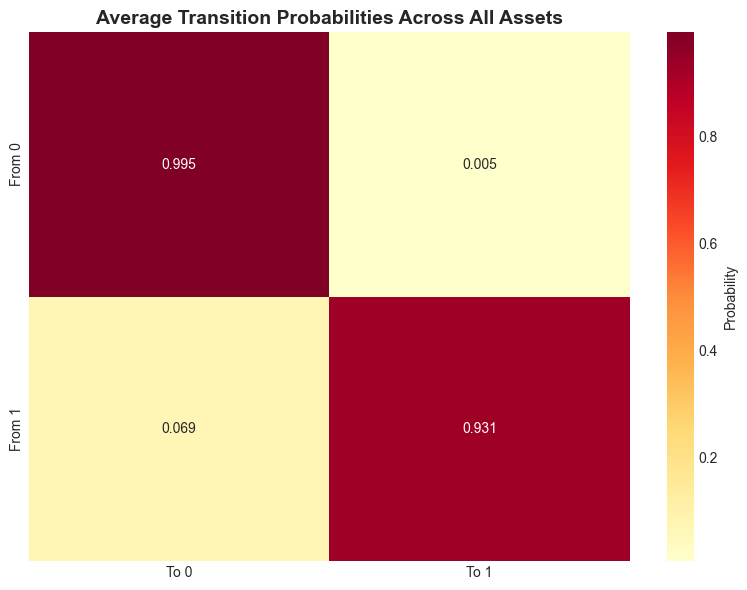

In [80]:
# Heatmap of average transition probabilities
n_msr_regimes = models[list(models.keys())[0]].msr.n_regimes

avg_trans_matrix = np.zeros((n_msr_regimes, n_msr_regimes))

for i in range(n_msr_regimes):
    for j in range(n_msr_regimes):
        col_name = f'Trans_P_{i}_to_{j}'
        avg_trans_matrix[i, j] = metadata_df[col_name].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(avg_trans_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=[f'To {i}' for i in range(n_msr_regimes)],
            yticklabels=[f'From {i}' for i in range(n_msr_regimes)],
            cbar_kws={'label': 'Probability'})
plt.title('Average Transition Probabilities Across All Assets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [81]:
# Identify assets with unusual transition probabilities
print("Assets with Unusual Transition Probabilities:")
print("="*80)

# Calculate persistence (diagonal probabilities)
for i in range(n_msr_regimes):
    col_name = f'Trans_P_{i}_to_{i}'
    metadata_df[f'Persistence_{i}'] = metadata_df[col_name]

persistence_cols = [f'Persistence_{i}' for i in range(n_msr_regimes)]

print("\nPersistence Probabilities (P(stay in same regime)):")
display(metadata_df[['Asset'] + persistence_cols].sort_values(persistence_cols[0]))

# Very low persistence (< 0.8)
print("\n\nAssets with LOW PERSISTENCE (<0.8):")
for i, col in enumerate(persistence_cols):
    low_persist = metadata_df[metadata_df[col] < 0.8][['Asset', col]]
    if len(low_persist) > 0:
        print(f"\nRegime {i}:")
        display(low_persist.sort_values(col))

Assets with Unusual Transition Probabilities:

Persistence Probabilities (P(stay in same regime)):


,Asset,Persistence_0,Persistence_1
7,Financial Select Sector SPDR,0.9920,0.9426
20,Technology Select Sector SPDR,0.9928,0.9672
0,Consumer Discretionary Select Sector SPDR,0.9931,0.9307
1,Nasdaq 100,0.9933,0.9693
5,Nasdaq Composite,0.9936,0.9673
23,Materials Select Sector SPDR,0.9936,0.9339
11,iShares S&P 500 Growth ETF,0.9937,0.9205
12,Invesco QQQ Trust,0.9940,0.9752
9,Health Care Select Sector SPDR,0.9942,0.8487
22,Energy Select Sector SPDR,0.9944,0.9181




Assets with LOW PERSISTENCE (<0.8):


## 9. Return Characteristics by Regime

In [82]:
def calculate_regime_return_characteristics(models: Dict) -> pd.DataFrame:
    """
    Calculate return statistics for each regime across all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Return characteristics by regime for all assets
    """
    regime_stats = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            for regime in regime_labels_aligned.unique():
                if pd.isna(regime):
                    continue
                
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                
                if len(regime_returns) > 0:
                    stats = {
                        'Asset': asset_name,
                        'Regime': int(regime),
                        'N_Obs': len(regime_returns),
                        'Mean': regime_returns.mean(),
                        'Std': regime_returns.std(),
                        'Sharpe': regime_returns.mean() / regime_returns.std() * np.sqrt(252) if regime_returns.std() > 0 else 0,
                        'Skewness': skew(regime_returns),
                        'Kurtosis': kurtosis(regime_returns),
                        'Min': regime_returns.min(),
                        'Max': regime_returns.max(),
                        'Pct_Positive': (regime_returns > 0).sum() / len(regime_returns) * 100
                    }
                    
                    regime_stats.append(stats)
        
        except Exception as e:
            print(f"❌ Error calculating return characteristics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(regime_stats)

regime_returns_df = calculate_regime_return_characteristics(models)
regime_returns_df['Mean'] *= 252  # Annualize mean returns
regime_returns_df['Std'] *= np.sqrt(252)  # Annualize std dev

print("Regime Return Characteristics:")
print("="*80)
display(regime_returns_df.groupby('Regime')[['Mean', 'Std', 'Sharpe', 'Skewness', 'Kurtosis']].describe())


Regime Return Characteristics:


Mean                                                           Std                                          \
       count    mean     std     min     25%     50%     75%     max count    mean     std     min     25%     50%   
Regime                                                                                                               
0       26.0  0.1478  0.0518  0.0813  0.1136  0.1354  0.1617  0.2738  26.0  0.1512  0.0240  0.1143  0.1312  0.1503   
1       26.0  0.1407  0.1126 -0.0133  0.0470  0.1343  0.2190  0.3799  26.0  0.2119  0.0211  0.1770  0.1946  0.2098   
2       26.0 -2.4246  1.8499 -7.0640 -3.5059 -1.9378 -1.4002  0.2155  25.0  0.4619  0.0678  0.3246  0.4155  0.4449   
3       26.0 -0.5475  0.3408 -1.2643 -0.6469 -0.4127 -0.3675 -0.0189  26.0  0.5781  0.1105  0.4684  0.5096  0.5486   

                       Sharpe                                                          Skewness                  \
           75%     max  count    mean     std      min     25%     50%     75%     max    count    mean     std   
Regime                                                                                                            
0       0.1639  0.2200   26.0  0.9852  0.3208   0.5749  0.7300  0.9361  1.2277  1.6767     26.0 -0.2644  0.1129   
1       0.2320  0.2469   26.0  0.6681  0.5486  -0.0624  0.2361  0.5982  0.9368  1.7751     26.0 -0.0528  0.0649   
2       0.4970  0.6129   26.0 -4.6219  3.3103 -11.5248 -6.5740 -4.2109 -2.3142  0.5013     25.0  0.2471  0.3603   
3       0.6009  0.9721   26.0 -0.9258  0.5005  -1.9237 -1.0733 -0.8452 -0.6784 -0.0356     26.0 -0.0021  0.2253   

                                               Kurtosis                                                           
           min     25%     50%     75%     max    count    mean     std     min     25%     50%     75%      max  
Regime                                                                                                            
0      -0.4808 -0.3165 -0.2721 -0.2291  0.0691     26.0  1.2870  0.3735  0.6070  1.1067  1.2973  1.5740   2.0541  
1      -0.1890 -0.0762 -0.0417 -0.0137  0.0835     26.0  0.1797  0.2023 -0.2537  0.1004  0.2048  0.2541   0.6430  
2      -0.1621 -0.0040  0.1186  0.4102  1.0097     25.0 -0.2057  0.4315 -1.1244 -0.4781 -0.2896  0.0859   0.5693  
3      -0.3462 -0.1378  0.0190  0.1328  0.4408     26.0  1.3514  2.5203 -0.3665  0.4691  0.8932  1.3622  13.4308

In [83]:
regime_returns_df

,Asset,Regime,N_Obs,Mean,Std,Sharpe,Skewness,Kurtosis,Min,Max,Pct_Positive
0,Consumer Discretionary Select Sector SPDR,0,4432,0.1494,0.1574,0.9491,-0.2325,1.3836,-0.0441,0.0459,53.9034
1,Consumer Discretionary Select Sector SPDR,1,861,0.0251,0.2400,0.1045,-0.0033,-0.1992,-0.0432,0.0473,49.7096
2,Consumer Discretionary Select Sector SPDR,3,408,-0.0189,0.5313,-0.0356,-0.2481,0.7743,-0.1355,0.0933,49.2647
3,Consumer Discretionary Select Sector SPDR,2,74,-2.1563,0.4144,-5.2037,-0.0012,-0.2896,-0.0826,0.0509,35.1351
4,Nasdaq 100,1,652,0.3799,0.2140,1.7751,-0.0009,0.1838,-0.0370,0.0404,57.8221
...,...,...,...,...,...,...,...,...,...,...,...
99,Utilities Select Sector SPDR,2,1,-6.9833,NaN,0.0000,NaN,NaN,-0.0277,-0.0277,0.0000
100,Industrial Select Sector SPDR,0,4346,0.1106,0.1510,0.7325,-0.2437,1.1385,-0.0416,0.0390,53.7736
101,Industrial Select Sector SPDR,1,906,0.1536,0.2223,0.6910,-0.1890,0.0886,-0.0453,0.0406,52.7594
102,Industrial Select Sector SPDR,3,449,-0.2781,0.5104,-0.5450,-0.1119,0.9018,-0.1204,0.1191,49.6659


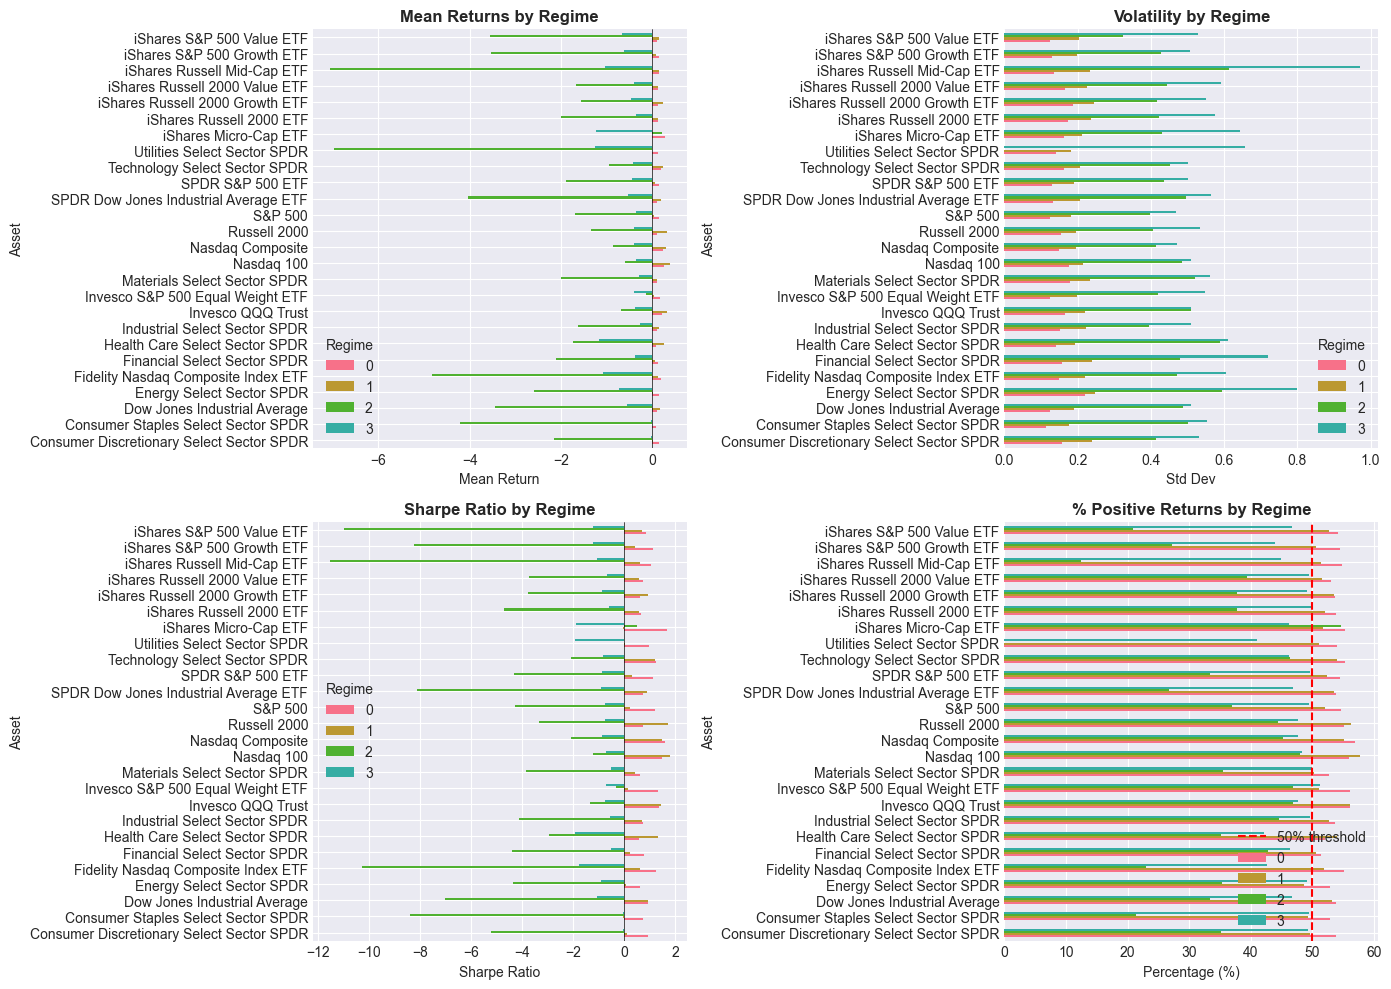

In [84]:
# Compare return characteristics across regimes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean returns by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Mean').plot.barh(ax=axes[0,0])
axes[0,0].set_title('Mean Returns by Regime', fontweight='bold')
axes[0,0].set_xlabel('Mean Return')
axes[0,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Volatility by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Std').plot.barh(ax=axes[0,1])
axes[0,1].set_title('Volatility by Regime', fontweight='bold')
axes[0,1].set_xlabel('Std Dev')

# Sharpe ratio by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Sharpe').plot.barh(ax=axes[1,0])
axes[1,0].set_title('Sharpe Ratio by Regime', fontweight='bold')
axes[1,0].set_xlabel('Sharpe Ratio')
axes[1,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Percentage positive by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Pct_Positive').plot.barh(ax=axes[1,1])
axes[1,1].set_title('% Positive Returns by Regime', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(50, color='red', linestyle='--', label='50% threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [85]:
# Identify poorly differentiated regimes based on returns
print("Regime Differentiation Analysis:")
print("="*80)

for asset_name in regime_returns_df['Asset'].unique():
    asset_data = regime_returns_df[regime_returns_df['Asset'] == asset_name]
    
    if len(asset_data) >= 2:
        # Check if regimes have similar returns
        mean_diff = abs(asset_data['Mean'].max() - asset_data['Mean'].min())
        std_diff = abs(asset_data['Std'].max() - asset_data['Std'].min())
        
        # Flag if differences are small
        if mean_diff < 0.0005:  # Very small mean difference
            print(f"\n⚠️  {asset_name}: WEAK Mean Differentiation")
            print(f"   Mean difference: {mean_diff:.6f}")
            display(asset_data[['Regime', 'Mean', 'Std', 'Sharpe']])

Regime Differentiation Analysis:


## 10. Model Performance Metrics

In [86]:
def calculate_model_performance_metrics(models: Dict) -> pd.DataFrame:
    """
    Calculate performance metrics for all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Performance metrics for all models
    """
    performance_metrics = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align returns and regime_labels on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            # Number of parameters
            n_regimes = model.msr.n_regimes
            n_params = n_regimes * 3 + n_regimes * (n_regimes - 1)  # means, stds, betas, transition probs
            
            # Log-likelihood (approximate)
            log_likelihood = 0
            for regime in range(n_regimes):
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                if len(regime_returns) > 0:
                    ll = -0.5 * len(regime_returns) * np.log(2 * np.pi * model.msr.stds[regime]**2)
                    ll -= np.sum((regime_returns - model.msr.means[regime])**2) / (2 * model.msr.stds[regime]**2)
                    log_likelihood += ll
            
            # AIC and BIC
            n_obs = len(returns_aligned)
            aic = 2 * n_params - 2 * log_likelihood
            bic = n_params * np.log(n_obs) - 2 * log_likelihood
            
            metrics = {
                'Asset': asset_name,
                'Log_Likelihood': log_likelihood,
                'AIC': aic,
                'BIC': bic,
                'N_Params': n_params,
                'N_Obs': n_obs,
                'AIC_per_Obs': aic / n_obs,
                'BIC_per_Obs': bic / n_obs
            }
            
            performance_metrics.append(metrics)
            
        except Exception as e:
            print(f"❌ Error calculating performance metrics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(performance_metrics)

performance_df = calculate_model_performance_metrics(models)

print("Model Performance Metrics:")
print("="*80)
if len(performance_df) > 0:
    display(performance_df.sort_values('BIC'))
else:
    print("❌ No performance metrics calculated")


Model Performance Metrics:


,Asset,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs
17,Dow Jones Industrial Average,24434.0439,-48852.0878,-48796.1463,8,8044,-6.0731,-6.0662
19,S&P 500,23813.6784,-47611.3569,-47555.4154,8,8044,-5.9189,-5.9119
13,Russell 2000,22367.1936,-44718.3872,-44662.4458,8,8044,-5.5592,-5.5523
15,SPDR S&P 500 ETF,21366.4043,-42716.8087,-42661.6821,8,7265,-5.8798,-5.8722
5,Nasdaq Composite,21146.3506,-42276.7012,-42220.7598,8,8044,-5.2557,-5.2487
1,Nasdaq 100,19806.8590,-39597.7179,-39541.7765,8,8044,-4.9226,-4.9157
14,SPDR Dow Jones Industrial Average ETF,17743.9481,-35471.8962,-35418.2881,8,6009,-5.9031,-5.8942
2,Consumer Staples Select Sector SPDR,17271.8641,-34527.7283,-34474.4379,8,5775,-5.9788,-5.9696
9,Health Care Select Sector SPDR,17006.2829,-33996.5658,-33943.2754,8,5775,-5.8869,-5.8776
25,Industrial Select Sector SPDR,15946.4410,-31876.8820,-31823.5916,8,5775,-5.5198,-5.5106


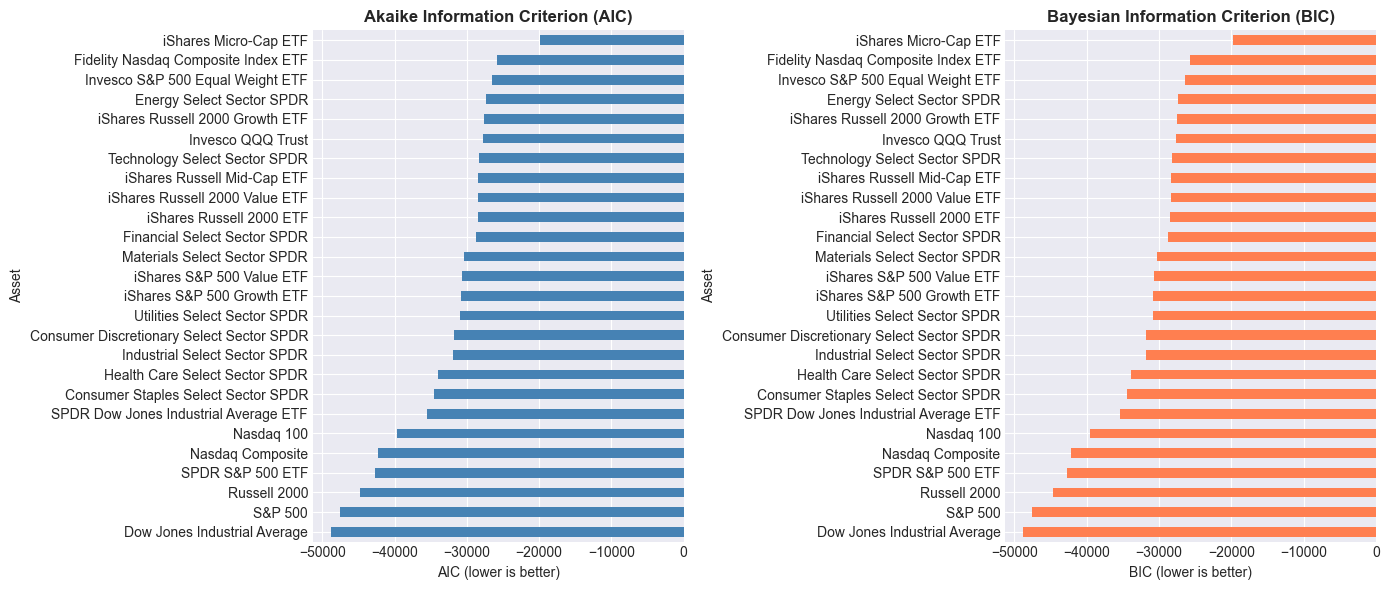


Best Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
17,Dow Jones Industrial Average,24434.0439,-48852.0878,-48796.1463
19,S&P 500,23813.6784,-47611.3569,-47555.4154
13,Russell 2000,22367.1936,-44718.3872,-44662.4458
15,SPDR S&P 500 ETF,21366.4043,-42716.8087,-42661.6821
5,Nasdaq Composite,21146.3506,-42276.7012,-42220.7598



Worst Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
3,iShares Micro-Cap ETF,9921.3404,-19826.6808,-19776.1231
21,Fidelity Nasdaq Composite Index ETF,12886.4892,-25756.9784,-25705.5497
4,Invesco S&P 500 Equal Weight ETF,13242.6514,-26469.3028,-26417.6893
22,Energy Select Sector SPDR,13695.4780,-27374.9560,-27321.6657
16,iShares Russell 2000 Growth ETF,13810.1427,-27604.2854,-27551.5737


In [87]:
# Visualize performance metrics
if len(performance_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # AIC
    performance_df.sort_values('AIC').plot.barh(x='Asset', y='AIC', ax=axes[0], 
                                                 color='steelblue', legend=False)
    axes[0].set_title('Akaike Information Criterion (AIC)', fontweight='bold')
    axes[0].set_xlabel('AIC (lower is better)')

    # BIC
    performance_df.sort_values('BIC').plot.barh(x='Asset', y='BIC', ax=axes[1], 
                                                 color='coral', legend=False)
    axes[1].set_title('Bayesian Information Criterion (BIC)', fontweight='bold')
    axes[1].set_xlabel('BIC (lower is better)')

    plt.tight_layout()
    plt.show()

    print("\nBest Performing Models (by BIC):")
    display(performance_df.nsmallest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])

    print("\nWorst Performing Models (by BIC):")
    display(performance_df.nlargest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])
else:
    print("❌ No performance data to visualize")


## 11. Regime Stability Analysis

In [88]:
# Combine with earlier duration metrics
stability_df = metadata_df[['Asset', 'N_Regime_Changes', 'Avg_Regime_Duration']].merge(
    duration_df[['Asset', 'Pct_Single_Period', 'Std_Duration']], 
    on='Asset'
)

# Add regime change frequency
stability_df['Changes_Per_100_Periods'] = (stability_df['N_Regime_Changes'] / 
                                           metadata_df['N_Data_Points'] * 100)

print("Regime Stability Metrics:")
print("="*80)
display(stability_df.sort_values('Changes_Per_100_Periods', ascending=False))

Regime Stability Metrics:


,Asset,N_Regime_Changes,Avg_Regime_Duration,Pct_Single_Period,Std_Duration,Changes_Per_100_Periods
3,iShares Micro-Cap ETF,214,19.0884,3.2558,15.2052,5.1891
24,Utilities Select Sector SPDR,126,45.4724,5.5118,55.0940,2.1743
2,Consumer Staples Select Sector SPDR,116,49.3590,9.4017,102.5263,2.0017
21,Fidelity Nasdaq Composite Index ETF,85,53.2093,9.3023,92.7320,1.8494
4,Invesco S&P 500 Equal Weight ETF,86,53.8276,4.5977,79.3858,1.8286
7,Financial Select Sector SPDR,104,55.0000,4.7619,111.9945,1.7947
23,Materials Select Sector SPDR,100,57.1782,8.9109,122.8529,1.7256
22,Energy Select Sector SPDR,94,60.7895,12.6316,101.6384,1.6221
6,iShares Russell 2000 ETF,86,62.2414,4.5977,147.9933,1.5823
17,Dow Jones Industrial Average,126,63.3386,10.2362,124.1285,1.5625


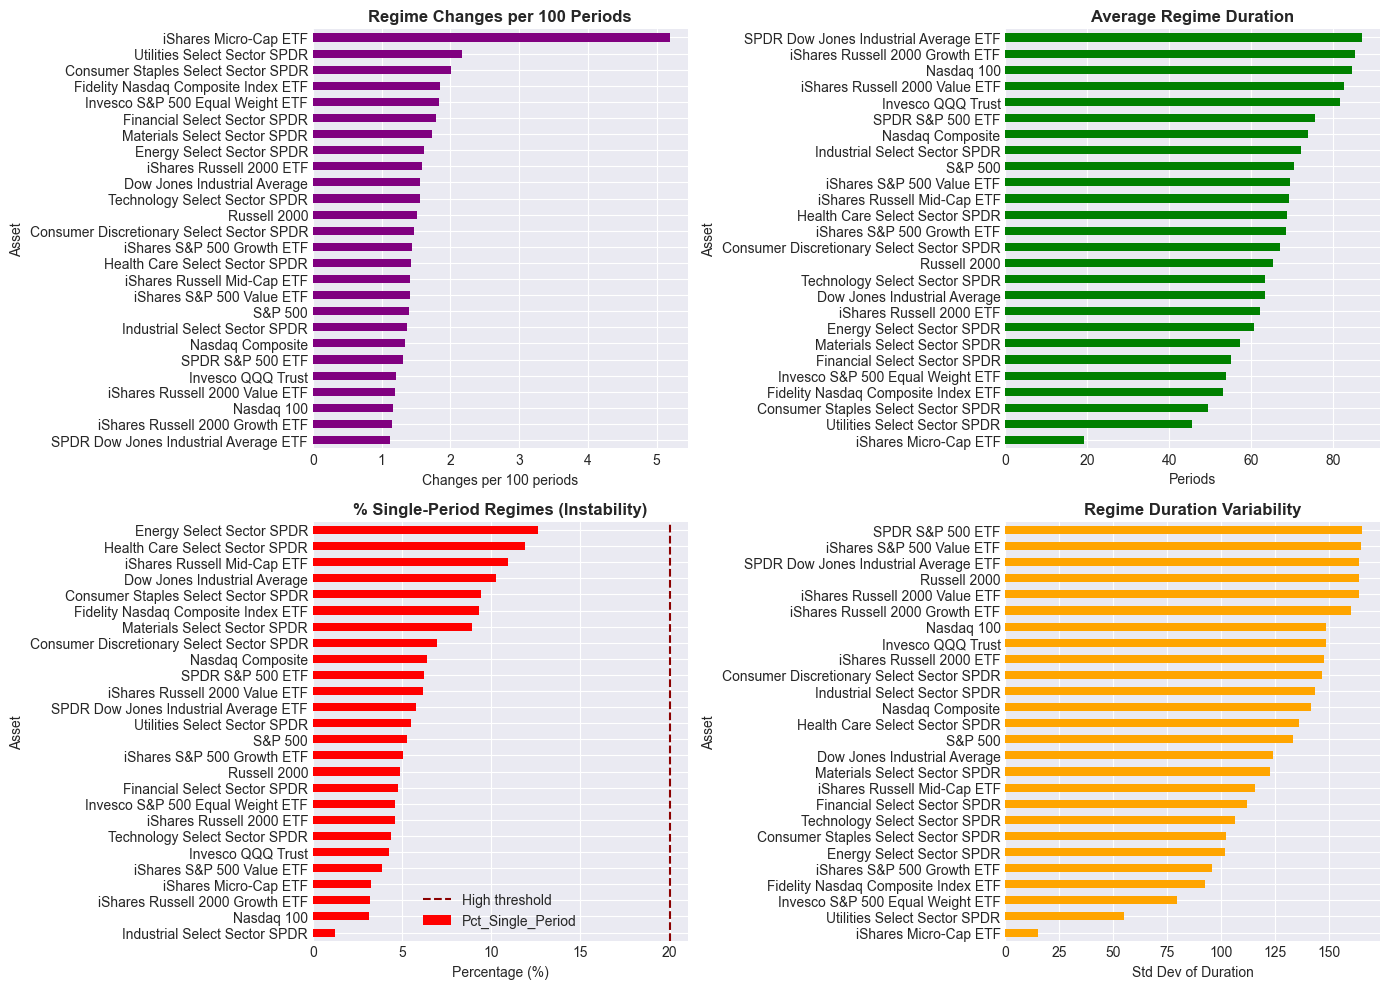

In [89]:
# Visualize stability metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Regime changes per 100 periods
stability_df.sort_values('Changes_Per_100_Periods').plot.barh(
    x='Asset', y='Changes_Per_100_Periods', ax=axes[0,0], color='purple', legend=False
)
axes[0,0].set_title('Regime Changes per 100 Periods', fontweight='bold')
axes[0,0].set_xlabel('Changes per 100 periods')

# Average regime duration
stability_df.sort_values('Avg_Regime_Duration').plot.barh(
    x='Asset', y='Avg_Regime_Duration', ax=axes[0,1], color='green', legend=False
)
axes[0,1].set_title('Average Regime Duration', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Percentage single-period regimes
stability_df.sort_values('Pct_Single_Period').plot.barh(
    x='Asset', y='Pct_Single_Period', ax=axes[1,0], color='red', legend=False
)
axes[1,0].set_title('% Single-Period Regimes (Instability)', fontweight='bold')
axes[1,0].set_xlabel('Percentage (%)')
axes[1,0].axvline(20, color='darkred', linestyle='--', label='High threshold')
axes[1,0].legend()

# Duration variability
stability_df.sort_values('Std_Duration').plot.barh(
    x='Asset', y='Std_Duration', ax=axes[1,1], color='orange', legend=False
)
axes[1,1].set_title('Regime Duration Variability', fontweight='bold')
axes[1,1].set_xlabel('Std Dev of Duration')

plt.tight_layout()
plt.show()

In [90]:
# Identify unstable models
print("Models with Stability Issues:")
print("="*80)

print("\n1. HIGH REGIME SWITCHING (>15 changes per 100 periods):")
high_switching = stability_df[stability_df['Changes_Per_100_Periods'] > 15].sort_values(
    'Changes_Per_100_Periods', ascending=False
)
if len(high_switching) > 0:
    display(high_switching)
else:
    print("  ✓ None found")

print("\n2. HIGH INSTABILITY (>20% single-period regimes):")
high_instability = stability_df[stability_df['Pct_Single_Period'] > 20].sort_values(
    'Pct_Single_Period', ascending=False
)
if len(high_instability) > 0:
    display(high_instability)
else:
    print("  ✓ None found")

Models with Stability Issues:

1. HIGH REGIME SWITCHING (>15 changes per 100 periods):
  ✓ None found

2. HIGH INSTABILITY (>20% single-period regimes):
  ✓ None found


## 12. Parameter Sensitivity Visualization

In [91]:
# Merge all dataframes for comprehensive analysis
comprehensive_df = metadata_df.merge(duration_df, on='Asset', suffixes=('', '_dur'))
comprehensive_df = comprehensive_df.merge(performance_df, on='Asset')
comprehensive_df = comprehensive_df.merge(stability_df[['Asset', 'Changes_Per_100_Periods']], on='Asset')

print("Comprehensive Dataset Shape:", comprehensive_df.shape)
print("\nFirst few rows:")
display(comprehensive_df.head())

Comprehensive Dataset Shape: (26, 51)

First few rows:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_n_lookback,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1,Mean_Diff,Std_Diff,Regime_Diversity_Score,Persistence_0,Persistence_1,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs,Changes_Per_100_Periods
0,Consumer Discretionary Select Sector SPDR,5795,2,4,18,10,60,20,2.00,85,67.1512,76.7446,4432,14.9091,861,1.2814,74,7.0649,408,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307,0.0017,0.0245,0.4735,0.9931,0.9307,67.1395,21.0,146.7467,1,968,8.0,42.5,86,6.9767,15924.5421,-31833.0842,-31779.7939,8,5775,-5.5122,-5.5030,1.4668
1,Nasdaq 100,8064,2,4,30,10,60,20,2.00,94,84.6737,73.9557,5949,8.1054,652,8.1179,653,9.8210,790,0.0010,0.0127,0.0036,-0.0019,0.0333,-0.0617,0.9933,0.0067,0.0307,0.9693,0.0030,0.0207,0.3807,0.9933,0.9693,84.6632,27.0,148.6043,1,999,10.5,92.5,95,3.1579,19806.8590,-39597.7179,-39541.7765,8,8044,-4.9226,-4.9157,1.1657
2,Consumer Staples Select Sector SPDR,5795,2,4,27,10,35,20,0.50,116,49.3590,72.1385,4166,25.6277,1480,0.2424,14,1.9913,115,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215,0.0021,0.0389,0.5116,0.9951,0.8215,49.3504,11.0,102.5263,1,580,4.0,38.0,117,9.4017,17271.8641,-34527.7283,-34474.4379,8,5775,-5.9788,-5.9696,2.0017
3,iShares Micro-Cap ETF,4124,2,4,6,2,25,20,1.75,214,19.0884,47.9288,1967,43.4698,1784,2.8509,117,5.7505,236,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509,0.0032,0.0296,0.2929,0.9954,0.9509,19.0837,16.0,15.2052,1,85,6.5,26.0,215,3.2558,9921.3404,-19826.6808,-19776.1231,8,4104,-4.8311,-4.8187,5.1891
4,Invesco S&P 500 Equal Weight ETF,4703,2,4,5,9,35,20,0.50,86,53.8276,71.2150,3335,20.6492,967,1.0463,49,7.0895,332,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573,0.0024,0.0287,0.4209,0.9960,0.9573,53.8161,24.0,79.3858,1,462,7.0,67.5,87,4.5977,13242.6514,-26469.3028,-26417.6893,8,4683,-5.6522,-5.6412,1.8286


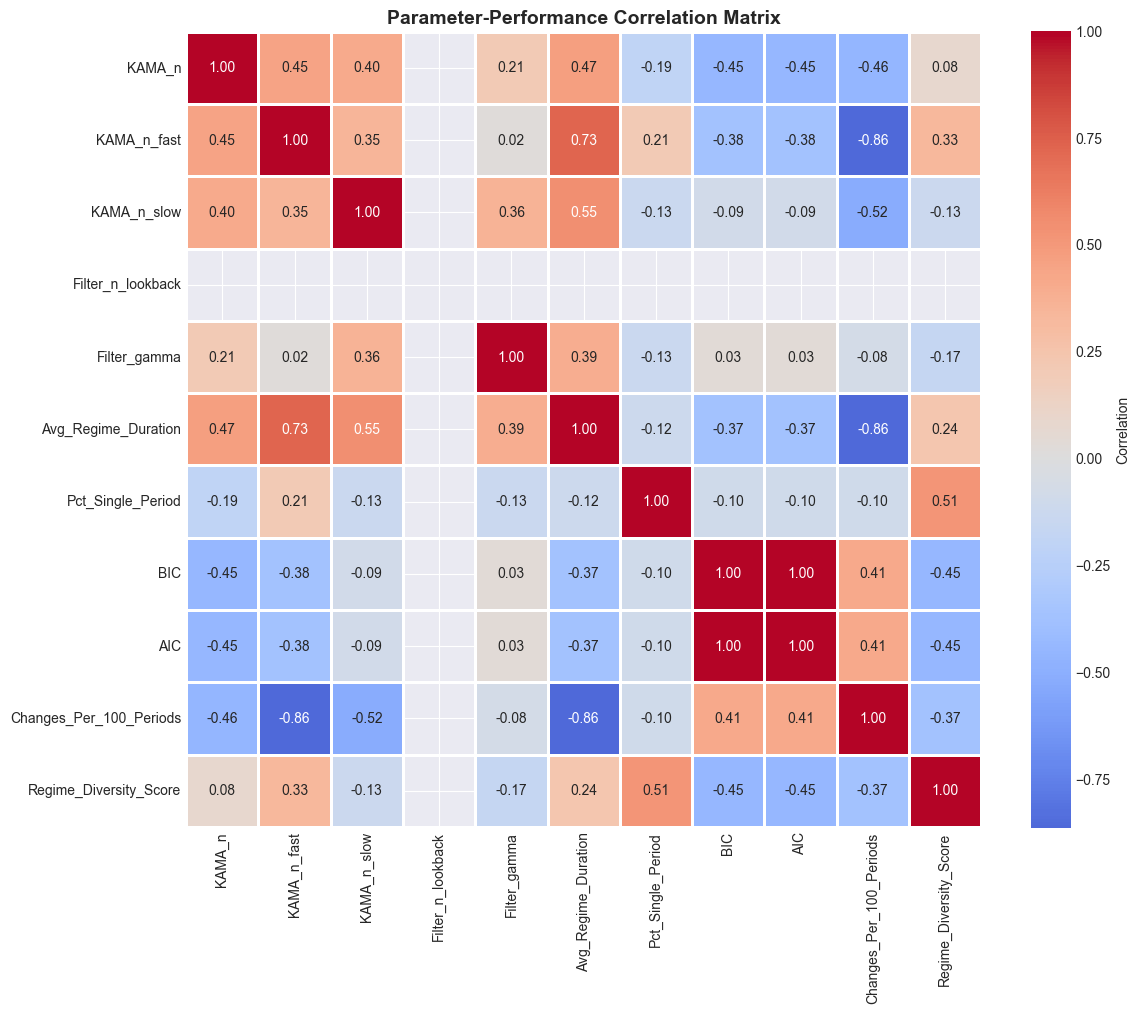


Strongest Correlations with Performance Metrics:

Correlations with BIC (model quality):
  AIC: 1.000
  Regime_Diversity_Score: -0.446
  KAMA_n: -0.446
  Changes_Per_100_Periods: 0.411
  KAMA_n_fast: -0.376


In [92]:
# Correlation matrix of key parameters and performance metrics
key_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow',
    'Filter_n_lookback', 'Filter_gamma',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'AIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter columns that exist
available_cols = [col for col in key_columns if col in comprehensive_df.columns]

correlation_matrix = comprehensive_df[available_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Parameter-Performance Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Correlations with Performance Metrics:")
print("="*80)

# Find strongest correlations with BIC
if 'BIC' in correlation_matrix.columns:
    bic_corr = correlation_matrix['BIC'].drop('BIC').abs().sort_values(ascending=False)
    print("\nCorrelations with BIC (model quality):")
    for param, corr in bic_corr.head(5).items():
        print(f"  {param}: {correlation_matrix.loc[param, 'BIC']:.3f}")

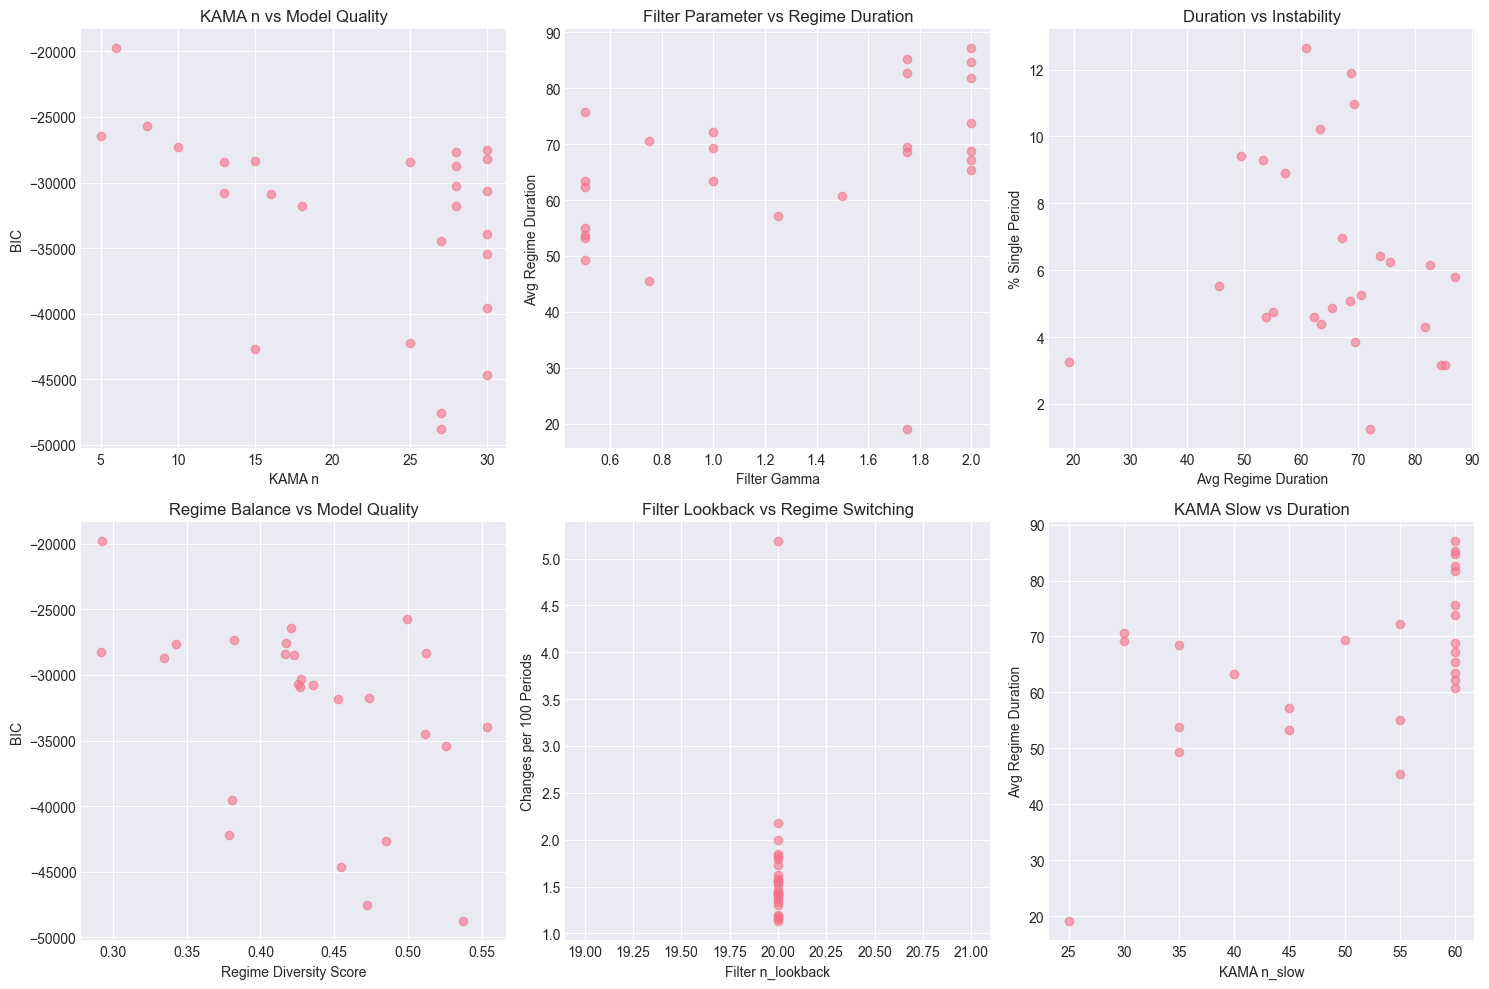

In [93]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# KAMA_n vs BIC
if 'BIC' in comprehensive_df.columns:
    axes[0,0].scatter(comprehensive_df['KAMA_n'], comprehensive_df['BIC'], alpha=0.6)
    axes[0,0].set_xlabel('KAMA n')
    axes[0,0].set_ylabel('BIC')
    axes[0,0].set_title('KAMA n vs Model Quality')

# Filter gamma vs Avg Duration
axes[0,1].scatter(comprehensive_df['Filter_gamma'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[0,1].set_xlabel('Filter Gamma')
axes[0,1].set_ylabel('Avg Regime Duration')
axes[0,1].set_title('Filter Parameter vs Regime Duration')

# Avg Duration vs Single Period %
axes[0,2].scatter(comprehensive_df['Avg_Regime_Duration'], comprehensive_df['Pct_Single_Period'], alpha=0.6)
axes[0,2].set_xlabel('Avg Regime Duration')
axes[0,2].set_ylabel('% Single Period')
axes[0,2].set_title('Duration vs Instability')

# Diversity Score vs BIC
if 'BIC' in comprehensive_df.columns and 'Regime_Diversity_Score' in comprehensive_df.columns:
    axes[1,0].scatter(comprehensive_df['Regime_Diversity_Score'], comprehensive_df['BIC'], alpha=0.6)
    axes[1,0].set_xlabel('Regime Diversity Score')
    axes[1,0].set_ylabel('BIC')
    axes[1,0].set_title('Regime Balance vs Model Quality')

# n_lookback vs Changes per 100
axes[1,1].scatter(comprehensive_df['Filter_n_lookback'], comprehensive_df['Changes_Per_100_Periods'], alpha=0.6)
axes[1,1].set_xlabel('Filter n_lookback')
axes[1,1].set_ylabel('Changes per 100 Periods')
axes[1,1].set_title('Filter Lookback vs Regime Switching')

# KAMA n_slow vs Avg Duration
axes[1,2].scatter(comprehensive_df['KAMA_n_slow'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[1,2].set_xlabel('KAMA n_slow')
axes[1,2].set_ylabel('Avg Regime Duration')
axes[1,2].set_title('KAMA Slow vs Duration')

plt.tight_layout()
plt.show()

## 13. Cross-Asset Regime Correlation

In [94]:
def build_regime_label_matrix(models: Dict) -> pd.DataFrame:
    """
    Build a matrix of regime labels across all assets.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Matrix with dates as index and assets as columns containing regime labels
    """
    regime_data = {}
    
    for asset_name, model in models.items():
        regime_data[asset_name] = model.regime_labels
    
    regime_matrix = pd.DataFrame(regime_data)
    return regime_matrix

regime_matrix = build_regime_label_matrix(models)

print("Regime Label Matrix:")
print("="*80)
print(f"Shape: {regime_matrix.shape}")
print(f"Date range: {regime_matrix.index.min()} to {regime_matrix.index.max()}")
print("\Last few rows:")
display(regime_matrix.tail())

Regime Label Matrix:
Shape: (8063, 26)
Date range: 1990-01-03 00:00:00 to 2021-12-31 00:00:00
\Last few rows:


,Consumer Discretionary Select Sector SPDR,Nasdaq 100,Consumer Staples Select Sector SPDR,iShares Micro-Cap ETF,Invesco S&P 500 Equal Weight ETF,Nasdaq Composite,iShares Russell 2000 ETF,Financial Select Sector SPDR,iShares S&P 500 Value ETF,Health Care Select Sector SPDR,iShares Russell 2000 Value ETF,iShares S&P 500 Growth ETF,Invesco QQQ Trust,Russell 2000,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,Dow Jones Industrial Average,iShares Russell Mid-Cap ETF,S&P 500,Technology Select Sector SPDR,Fidelity Nasdaq Composite Index ETF,Energy Select Sector SPDR,Materials Select Sector SPDR,Utilities Select Sector SPDR,Industrial Select Sector SPDR
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-28,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-29,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


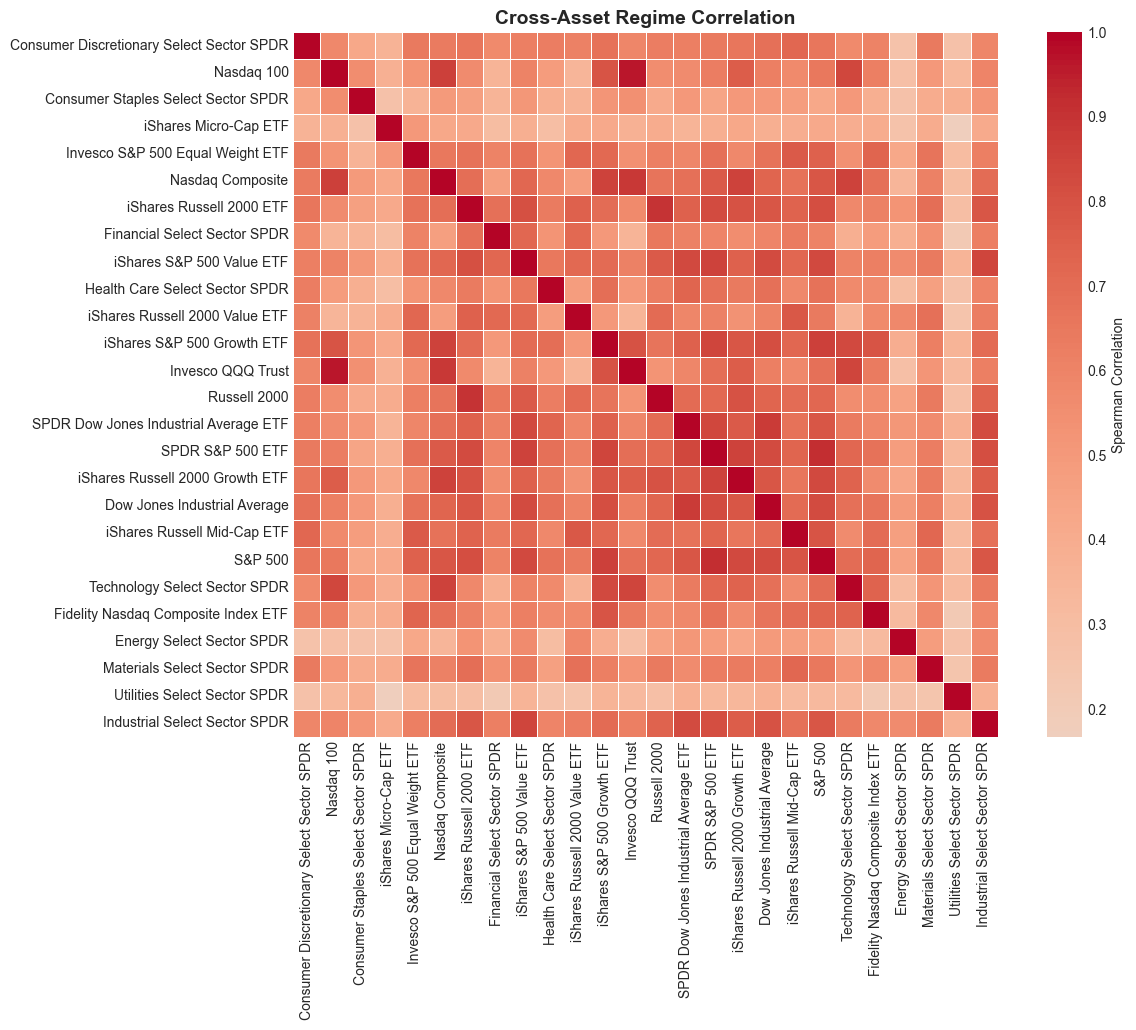


Strongest Cross-Asset Regime Correlations:

Highest Positive Correlations:


,Asset 1,Asset 2,Correlation
67,Nasdaq 100,Invesco QQQ Trust,0.9649
186,SPDR S&P 500 ETF,S&P 500,0.9194
84,iShares Russell 2000 ETF,Russell 2000,0.9001
71,Nasdaq Composite,Invesco QQQ Trust,0.8891
150,SPDR Dow Jones Industrial Average ETF,Dow Jones Industrial Average,0.8800
182,iShares S&P 500 Growth ETF,S&P 500,0.8665
11,Nasdaq 100,Nasdaq Composite,0.8584
135,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,0.8565
195,Nasdaq Composite,Technology Select Sector SPDR,0.8553
125,Nasdaq Composite,iShares Russell 2000 Growth ETF,0.8534



Highest Negative Correlations:


,Asset 1,Asset 2,Correlation
233,Consumer Staples Select Sector SPDR,Energy Select Sector SPDR,0.2703
5,Consumer Staples Select Sector SPDR,iShares Micro-Cap ETF,0.2702
285,Health Care Select Sector SPDR,Utilities Select Sector SPDR,0.2692
234,iShares Micro-Cap ETF,Energy Select Sector SPDR,0.2625
231,Consumer Discretionary Select Sector SPDR,Energy Select Sector SPDR,0.2621
286,iShares Russell 2000 Value ETF,Utilities Select Sector SPDR,0.2550
299,Materials Select Sector SPDR,Utilities Select Sector SPDR,0.2449
297,Fidelity Nasdaq Composite Index ETF,Utilities Select Sector SPDR,0.2167
283,Financial Select Sector SPDR,Utilities Select Sector SPDR,0.2164
279,iShares Micro-Cap ETF,Utilities Select Sector SPDR,0.1675


In [95]:
# Calculate regime correlation (using aligned dates only)
regime_corr = regime_matrix.corr(method='spearman')  # Spearman for ordinal data

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(regime_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})
plt.title('Cross-Asset Regime Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Cross-Asset Regime Correlations:")
print("="*80)

# Get upper triangle to avoid duplicates
mask = np.triu(np.ones_like(regime_corr, dtype=bool), k=1)
regime_corr_upper = regime_corr.where(mask)

# Find top correlations
correlations = []
for col in regime_corr_upper.columns:
    for idx in regime_corr_upper.index:
        val = regime_corr_upper.loc[idx, col]
        if not pd.isna(val):
            correlations.append({
                'Asset 1': idx,
                'Asset 2': col,
                'Correlation': val
            })

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
print("\nHighest Positive Correlations:")
display(corr_df.head(10))

print("\nHighest Negative Correlations:")
display(corr_df.tail(10))

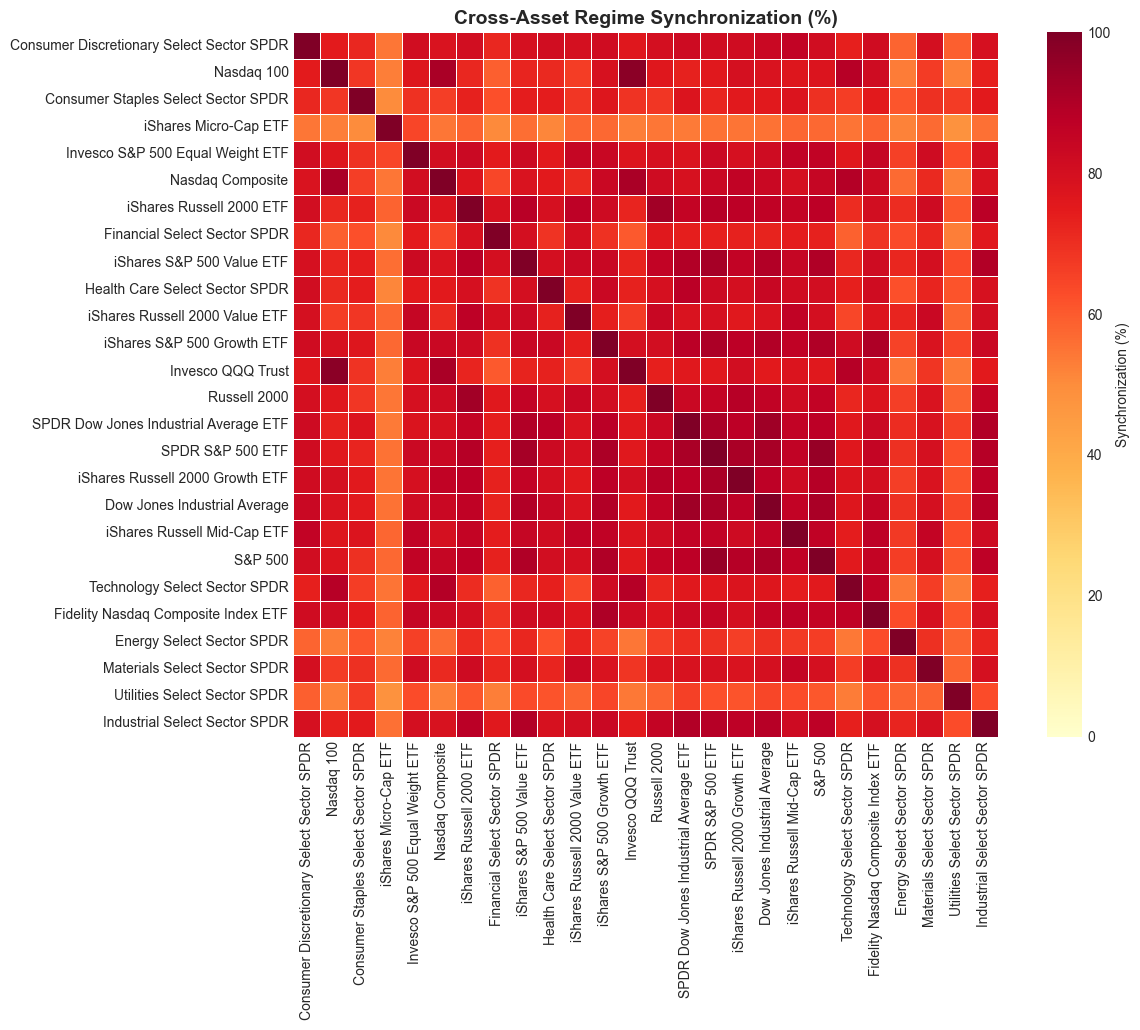


Asset Pairs with Highest Regime Synchronization:


,Asset 1,Asset 2,Sync %
35,Nasdaq 100,Invesco QQQ Trust,97.2742
273,SPDR S&P 500 ETF,S&P 500,95.2374
261,SPDR Dow Jones Industrial Average ETF,Dow Jones Industrial Average,93.7261
141,iShares Russell 2000 ETF,Russell 2000,92.7239
178,iShares S&P 500 Value ETF,SPDR S&P 500 ETF,91.8375
271,SPDR S&P 500 ETF,Dow Jones Industrial Average,91.6311
121,Nasdaq Composite,Invesco QQQ Trust,91.2808
270,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,91.2323
28,Nasdaq 100,Nasdaq Composite,91.0865
259,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,91.0634


In [96]:
# Calculate regime synchronization percentage
def calculate_regime_sync(regime_matrix: pd.DataFrame) -> pd.DataFrame:
    """Calculate percentage of time assets are in the same regime."""
    assets = regime_matrix.columns
    n_assets = len(assets)
    
    sync_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)
    
    for i, asset1 in enumerate(assets):
        for j, asset2 in enumerate(assets):
            if i == j:
                sync_matrix.loc[asset1, asset2] = 100.0
            else:
                # Find common dates
                common_dates = regime_matrix[[asset1, asset2]].dropna().index
                if len(common_dates) > 0:
                    same_regime = (regime_matrix.loc[common_dates, asset1] == 
                                  regime_matrix.loc[common_dates, asset2])
                    sync_matrix.loc[asset1, asset2] = same_regime.sum() / len(common_dates) * 100
    
    return sync_matrix.astype(float)

sync_matrix = calculate_regime_sync(regime_matrix)

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(sync_matrix, annot=False, fmt='.1f', cmap='YlOrRd', 
            vmin=0, vmax=100, square=True, linewidths=0.5,
            cbar_kws={'label': 'Synchronization (%)'})
plt.title('Cross-Asset Regime Synchronization (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAsset Pairs with Highest Regime Synchronization:")
print("="*80)

# Convert to long format
sync_data = []
for i, asset1 in enumerate(sync_matrix.index):
    for j, asset2 in enumerate(sync_matrix.columns):
        if i < j:  # Upper triangle only
            sync_data.append({
                'Asset 1': asset1,
                'Asset 2': asset2,
                'Sync %': sync_matrix.loc[asset1, asset2]
            })

sync_df = pd.DataFrame(sync_data).sort_values('Sync %', ascending=False)
display(sync_df.head(10))

## 14. Identify Outliers and Anomalies

In [97]:
def identify_outliers_zscore(df: pd.DataFrame, columns: list, threshold: float = 3.0) -> pd.DataFrame:
    """
    Identify outliers using z-score method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    threshold : float
        Z-score threshold (default: 3.0)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            col_outliers = df[z_scores > threshold]
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Z_Score'] = z_scores[z_scores > threshold]
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

# Define columns to check
outlier_check_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow',
    'Filter_gamma', 'Filter_n_lookback',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter available columns
available_outlier_cols = [col for col in outlier_check_columns if col in comprehensive_df.columns]

outliers = identify_outliers_zscore(comprehensive_df, available_outlier_cols, threshold=2.5)

print("Outlier Analysis (Z-score > 2.5):")
print("="*80)

if len(outliers) > 0:
    outlier_summary = outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    outlier_summary.columns = ['Asset', 'Outlier Parameters']
    display(outlier_summary)
    
    print("\nDetailed Outlier Information:")
    display(outliers[['Asset', 'Outlier_Column', 'Z_Score']].sort_values('Z_Score', ascending=False))
else:
    print("✓ No significant outliers found")

Outlier Analysis (Z-score > 2.5):


,Asset,Outlier Parameters
0,Utilities Select Sector SPDR,[KAMA_n_fast]
1,iShares Micro-Cap ETF,"[KAMA_n_fast, Avg_Regime_Duration, Changes_Per..."



Detailed Outlier Information:


,Asset,Outlier_Column,Z_Score
3,iShares Micro-Cap ETF,Changes_Per_100_Periods,4.6907
3,iShares Micro-Cap ETF,KAMA_n_fast,3.9077
3,iShares Micro-Cap ETF,Avg_Regime_Duration,3.2257
24,Utilities Select Sector SPDR,KAMA_n_fast,2.8439


In [98]:
# IQR-based outlier detection
def identify_outliers_iqr(df: pd.DataFrame, columns: list, multiplier: float = 1.5) -> pd.DataFrame:
    """
    Identify outliers using IQR method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    multiplier : float
        IQR multiplier (default: 1.5)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Outlier_Value'] = col_outliers[col]
                col_outliers['Lower_Bound'] = lower_bound
                col_outliers['Upper_Bound'] = upper_bound
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

iqr_outliers = identify_outliers_iqr(comprehensive_df, available_outlier_cols, multiplier=1.5)

print("\nOutlier Analysis (IQR method):")
print("="*80)

if len(iqr_outliers) > 0:
    iqr_summary = iqr_outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    iqr_summary.columns = ['Asset', 'Outlier Parameters']
    display(iqr_summary)
else:
    print("✓ No significant outliers found")


Outlier Analysis (IQR method):


,Asset,Outlier Parameters
0,Dow Jones Industrial Average,[BIC]
1,Fidelity Nasdaq Composite Index ETF,[KAMA_n_fast]
2,Invesco S&P 500 Equal Weight ETF,[KAMA_n_fast]
3,S&P 500,[BIC]
4,Utilities Select Sector SPDR,[KAMA_n_fast]
5,iShares Micro-Cap ETF,"[KAMA_n_fast, Avg_Regime_Duration, Changes_Per..."
6,iShares S&P 500 Value ETF,[KAMA_n_fast]


In [99]:
# Identify problematic models based on multiple criteria
def flag_problematic_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flag models with multiple potential issues.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Comprehensive model data
    
    Returns:
    --------
    pd.DataFrame : Models with flags and issue counts
    """
    issues = df[['Asset']].copy()
    
    # Flag various issues
    issues['High_Instability'] = df['Pct_Single_Period'] > 20
    issues['Low_Differentiation'] = df['Regime_Diversity_Score'] > 0.6 if 'Regime_Diversity_Score' in df.columns else False
    issues['Short_Duration'] = df['Avg_Regime_Duration'] < 5
    issues['High_Switching'] = df['Changes_Per_100_Periods'] > 15
    issues['Poor_BIC'] = df['BIC'] > df['BIC'].quantile(0.75) if 'BIC' in df.columns else False
    
    # Count issues
    issue_cols = [col for col in issues.columns if col != 'Asset']
    issues['Total_Issues'] = issues[issue_cols].sum(axis=1)
    
    return issues.sort_values('Total_Issues', ascending=False)

problem_flags = flag_problematic_models(comprehensive_df)

print("Models Flagged for Potential Issues:")
print("="*80)

problem_models = problem_flags[problem_flags['Total_Issues'] > 0]
display(problem_models)

print(f"\n{len(problem_models)} out of {len(comprehensive_df)} models flagged with issues")

Models Flagged for Potential Issues:


,Asset,High_Instability,Low_Differentiation,Short_Duration,High_Switching,Poor_BIC,Total_Issues
3,iShares Micro-Cap ETF,False,False,False,False,True,1
4,Invesco S&P 500 Equal Weight ETF,False,False,False,False,True,1
22,Energy Select Sector SPDR,False,False,False,False,True,1
21,Fidelity Nasdaq Composite Index ETF,False,False,False,False,True,1
20,Technology Select Sector SPDR,False,False,False,False,True,1
12,Invesco QQQ Trust,False,False,False,False,True,1
16,iShares Russell 2000 Growth ETF,False,False,False,False,True,1



7 out of 26 models flagged with issues


## 15. Generate Improvement Recommendations

In [100]:
def generate_improvement_recommendations(
    metadata_df: pd.DataFrame,
    duration_df: pd.DataFrame,
    performance_df: pd.DataFrame,
    stability_df: pd.DataFrame,
    problem_flags: pd.DataFrame,
    regime_returns_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Generate comprehensive improvement recommendations based on all analyses.
    
    Parameters:
    -----------
    metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
        Analysis dataframes
    
    Returns:
    --------
    pd.DataFrame : Recommendations for each asset with priority scores
    """
    recommendations = []
    
    for asset in metadata_df['Asset'].unique():
        asset_recs = {'Asset': asset, 'Recommendations': [], 'Priority': 0}
        
        # Check problem flags
        asset_flags = problem_flags[problem_flags['Asset'] == asset]
        if len(asset_flags) > 0:
            flags = asset_flags.iloc[0]
            
            if flags.get('High_Instability', False):
                asset_recs['Recommendations'].append("⚠️  HIGH INSTABILITY: Increase filter gamma or n_lookback to reduce single-period regimes")
                asset_recs['Priority'] += 3
            
            if flags.get('Low_Differentiation', False):
                asset_recs['Recommendations'].append("⚠️  LOW REGIME DIFFERENTIATION: Consider increasing MSR regimes or revising KAMA parameters")
                asset_recs['Priority'] += 2
            
            if flags.get('Short_Duration', False):
                asset_recs['Recommendations'].append("⚠️  SHORT REGIME DURATION: Increase minimum regime duration filter")
                asset_recs['Priority'] += 2
            
            if flags.get('High_Switching', False):
                asset_recs['Recommendations'].append("⚠️  HIGH SWITCHING FREQUENCY: Adjust KAMA sensitivity (increase n or n_slow)")
                asset_recs['Priority'] += 2
            
            if flags.get('Poor_BIC', False):
                asset_recs['Recommendations'].append("⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count")
                asset_recs['Priority'] += 1
        
        # Check regime returns
        asset_regime_returns = regime_returns_df[regime_returns_df['Asset'] == asset]
        if len(asset_regime_returns) >= 2:
            mean_diff = abs(asset_regime_returns['Mean'].max() - asset_regime_returns['Mean'].min())
            if mean_diff < 0.01:  # Very small annualized return difference
                asset_recs['Recommendations'].append("💡 WEAK REGIME SEPARATION: Regimes show similar returns; verify KAMA trend detection")
                asset_recs['Priority'] += 2
        
        # KAMA parameter checks
        asset_meta = metadata_df[metadata_df['Asset'] == asset].iloc[0]
        if asset_meta['KAMA_n'] < 10:
            asset_recs['Recommendations'].append("💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise")
            asset_recs['Priority'] += 1
        
        if asset_meta['KAMA_n_slow'] > 100:
            asset_recs['Recommendations'].append("💡 KAMA SLOW PERIOD VERY HIGH: May miss important regime shifts")
            asset_recs['Priority'] += 1
        
        # Duration variability
        asset_dur = duration_df[duration_df['Asset'] == asset].iloc[0]
        if asset_dur['Std_Duration'] > asset_dur['Mean_Duration']:
            asset_recs['Recommendations'].append("💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints")
            asset_recs['Priority'] += 1
        
        # Add positive notes
        if asset_recs['Priority'] == 0:
            asset_recs['Recommendations'].append("✅ Model appears well-calibrated with no major issues detected")
        
        recommendations.append(asset_recs)
    
    recs_df = pd.DataFrame(recommendations)
    recs_df['N_Issues'] = recs_df['Recommendations'].apply(lambda x: len([r for r in x if '⚠️' in r or '💡' in r]))
    
    return recs_df.sort_values('Priority', ascending=False)

# Generate recommendations
if len(performance_df) > 0 and len(problem_flags) > 0:
    recommendations_df = generate_improvement_recommendations(
        metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
    )

    print("="*80)
    print("MODEL IMPROVEMENT RECOMMENDATIONS")
    print("="*80)
    print("\nPriority levels: Higher = More urgent\n")

    for _, row in recommendations_df.iterrows():
        print(f"\n{'='*80}")
        print(f"ASSET: {row['Asset']}")
        print(f"Priority Score: {row['Priority']} | Issues Found: {row['N_Issues']}")
        print(f"{'-'*80}")
        for rec in row['Recommendations']:
            print(f"  {rec}")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {len(recommendations_df[recommendations_df['Priority'] > 0])} assets need attention")
    print(f"{'='*80}\n")
    
    # Export recommendations
    recommendations_export = recommendations_df.copy()
    recommendations_export['Recommendations'] = recommendations_export['Recommendations'].apply(lambda x: ' | '.join(x))
    
    print("\nRecommendations Summary Table:")
    display(recommendations_export[['Asset', 'Priority', 'N_Issues', 'Recommendations']])
else:
    print("❌ Cannot generate recommendations - missing required data")


MODEL IMPROVEMENT RECOMMENDATIONS

Priority levels: Higher = More urgent


ASSET: Invesco S&P 500 Equal Weight ETF
Priority Score: 3 | Issues Found: 3
--------------------------------------------------------------------------------
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: Fidelity Nasdaq Composite Index ETF
Priority Score: 3 | Issues Found: 3
--------------------------------------------------------------------------------
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: iShares Micro-Cap ETF
Priority Score: 2 | Issues Found: 2
-----------------------------------------------------------------------------

,Asset,Priority,N_Issues,Recommendations
4,Invesco S&P 500 Equal Weight ETF,3,3,⚠️ POOR MODEL FIT: Review parameter choices o...
21,Fidelity Nasdaq Composite Index ETF,3,3,⚠️ POOR MODEL FIT: Review parameter choices o...
3,iShares Micro-Cap ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
22,Energy Select Sector SPDR,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
20,Technology Select Sector SPDR,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
12,Invesco QQQ Trust,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
16,iShares Russell 2000 Growth ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
0,Consumer Discretionary Select Sector SPDR,1,1,💡 HIGH DURATION VARIABILITY: Consider tighteni...
15,SPDR S&P 500 ETF,1,1,💡 HIGH DURATION VARIABILITY: Consider tighteni...
24,Utilities Select Sector SPDR,1,1,💡 HIGH DURATION VARIABILITY: Consider tighteni...
